# Evaluation of individual ions of the Seahorse dataset

This notebook further analysis evaluation workflow objects (sc_imputation_denoising.evaluation.evaluation_workflow) that were generated using the imputation_evaluation_mse.ipynb notebook.

In [ ]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import re
import ast
from tqdm import tqdm
import sklearn
from joblib import Parallel, delayed

# Matplotlib command for Jupyter notebooks only
%matplotlib inline
plt.style.use('tableau-colorblind10')

In [2]:
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising as scid

from sc_imputation_denoising.imputation.constants import const

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow,
)

sim_method = "mcar"

IE version 1.3


In [5]:
max_fdr = 1
n_cells = 0.1
n_ions = 0.2
dataset = "Mx_Seahorse"
repl = 1
cond = 4

In [20]:
conf = f"cond{cond}_c{n_cells}_i{n_ions}_fdr{max_fdr}_repl{repl}"
conf_ext = f"cond{cond}_{sim_method}_c{n_cells}_i{n_ions}_fdr{max_fdr}_repl{repl}"
save_to = f"/g/alexandr/Marius/imputation_evaluation/{dataset}_{conf_ext}"
if not os.path.exists(save_to):
    print("sample does not exist")
    # os.makedirs(save_to)
print(save_to)

cond_order_dict = dict(
    Mx_Seahorse=["NStim", "Stim", "2DG", "Oligo"],
    Lx_Glioblastoma=[
        "Naive_WT",
        "TMD_sM",
        "TMD_dM",
        "TMD_tM",
        "TMD_CD95_WT",
        "TMD_CD95_KO",
    ],
    Lx_Pancreatic_Cancer=["HPAF", "HPAC", "PSN1", "MiaPaca2"],
    Lx_HepaRG=["U", "F", "FI", "FIT"],
)

cond_order = cond_order_dict[dataset]
exclude_imps = [
    "dca_nb-conddisp",
    "dca_zinb-conddisp",
    "fancy_softbi",
    "bbmagic_1",
    "bbmagic_2",
    "bbmagic_3",
    "bbmagic_5",
    "fancy_soft",
    "knn_1",
    "MAGIC_t5",
    "ctrl_median",
    "ctrl_random",
]

/g/alexandr/Marius/imputation_evaluation/Mx_Seahorse_cond4_mcar_c0.1_i0.2_fdr1_repl1


In [7]:
wflow = evaluation_workflow.get_from_pickle(
    f"/scratch/klein/temp/evaluation_pickle_{dataset}_{conf_ext}_{repl}.pkl"
)

In [71]:
wflow.analysis_ions

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest

['C7H10O6+Cl',
 'C4H9O7P-H',
 'C4H7NO4+Cl',
 'C10H13N4O8P-H',
 'C5H4N4O-H',
 'C10H13N4O9P-H',
 'C10H16N2O3S+Cl',
 'C11H23N5O3S+Cl']

In [8]:
adata = wflow.dataset_dict[wflow.baseline_key]
# analysis_ions = ['C42H78NO7P+H', 'C44H80NO8P+K', 'C42H74NO8P+H', 'C45H80NO8P+H', 'C30H52NO8P+H', 'C33H58NO8P+H']
# analysis_ions = ['C43H78NO8P+K', 'C40H72NO8P+H', 'C40H76NO8P+Na', 'C26H52NO7P+Na']
analysis_ions = [
    "C4H7NO4-H",
    "C10H13N4O8P-H",
    "C9H13N2O9P-H",
    "C5H4N4O-H",
    "C5H5N5-H",
    "H4O7P2-H",
    "C5H9NO2-H",
    "C6H8O7-H",
    "C4H9NO2-H",
    "C8H16N2O3S-H",
    "C5H10N2O3-H",
    "C11H21N3O5+Cl",
    "C5H7NO3-H",
]

In [73]:
all_ions = adata.var_names
ion_df_list = []
for layer in list(set(adata.layers.keys()).difference(exclude_imps)):
    df = pd.DataFrame(
        adata[:, all_ions].layers[layer],
        columns=pd.MultiIndex.from_tuples([(layer, ion) for ion in all_ions]),
        index=adata.obs_names,
    )
    ion_df_list.append(df)

ion_df = pd.concat(ion_df_list, axis=1)
ion_df = pd.merge(
    ion_df, adata.obs[["condition", "sample"]], left_index=True, right_index=True
).set_index(["condition", "sample"], append=True)
ion_df.columns = pd.MultiIndex.from_tuples(ion_df.columns)
long_ion_df = ion_df.reset_index().melt(
    id_vars=["cell_id", "condition", "sample"], var_name=["layer", "ion"]
)
long_ion_df["imputation"] = long_ion_df["layer"]

/tmp/ipykernel_1205/1378025087.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ion_df = pd.merge(ion_df, adata.obs[['condition', 'sample']], left_index=True, right_index=True).set_index(['condition', 'sample'], append=True)


In [74]:
corr_df = long_ion_df.pivot(
    index=["cell_id", "condition", "sample", "ion"],
    columns=["imputation"],
    values="value",
).corr()

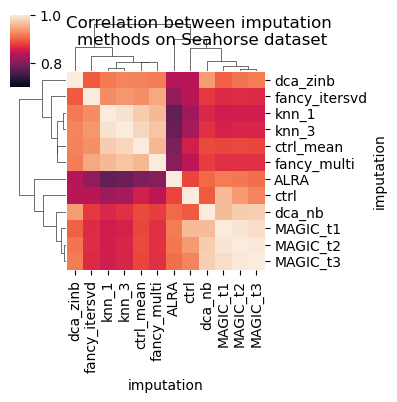

In [82]:
fig = sns.clustermap(corr_df, figsize=(4, 4), vmin=0.7)
fig.fig.suptitle("Correlation between imputation \nmethods on Seahorse dataset")
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/Seahorse_correlation_heatmap_imputations.pdf"
)
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/Seahorse_correlation_heatmap_imputations.png"
)

In [77]:
compare_layers_df = long_ion_df.pivot(
    index=["cell_id", "condition", "sample", "ion"],
    columns=["imputation"],
    values="value",
)

In [78]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = np.zeros(
    (len(compare_layers_df.columns), len(compare_layers_df.columns))
)
for k, column in enumerate(compare_layers_df.columns):
    for j, column2 in list(enumerate(compare_layers_df.columns))[k:]:
        if column != column2:
            cosine = cosine_similarity(
                compare_layers_df[column].values.reshape(1, -1),
                compare_layers_df[column2].values.reshape(1, -1),
            )
            cosine_matrix[k, j] = cosine_matrix[j, k] = cosine[0, 0]
        else:
            cosine_matrix[k, j] = 1

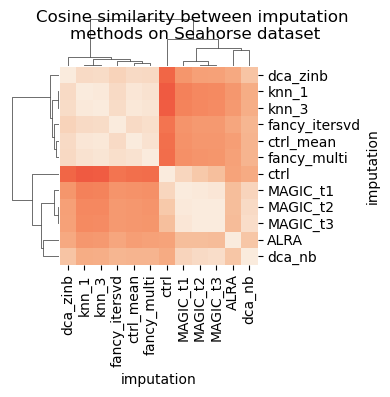

In [87]:
fig = sns.clustermap(
    pd.DataFrame(
        cosine_matrix,
        index=compare_layers_df.columns,
        columns=compare_layers_df.columns,
    ),
    figsize=(4, 4),
    vmin=0.7,
    cbar_pos=None,
)
fig.fig.suptitle("Cosine similarity between imputation \nmethods on Seahorse dataset")
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/Seahorse_cosine_heatmap_imputations.pdf"
)
fig.fig.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/Seahorse_cosine_heatmap_imputations.png"
)

In [182]:
count_df = long_ion_df.groupby(["layer", "ion", "condition"]).agg(
    {"value": [lambda x: len(x[x == 0]) / len(x)]}
)
count_df.columns = ["value"]
diff = (
    count_df.loc["ctrl"]
    .groupby("ion")
    .agg(lambda x: np.max(x) - np.min(x))
    .sort_values(by="value", ascending=False)
    .head(40)
    .index.values
)
var = (
    count_df.loc["ctrl"]
    .groupby("ion")
    .var()
    .sort_values("value", ascending=False)
    .head(40)
    .index.values
)
list(set(list(diff) + list(var)))

['C10H17N3O6-H',
 'C9H13N5O3-H',
 'C6H12O6-H',
 'C4H6O5-H',
 'C5H9NO3-H',
 'C4H7NO4+Cl',
 'C6H10O5+Cl',
 'C7H12N2O3-H',
 'C11H21N3O5+Cl',
 'C6H8O6+Cl',
 'C3H5O7P+Cl',
 'C20H24N-H',
 'C9H13N2O9P-H',
 'C5H8O5-H',
 'C6H6O5+Cl',
 'C5H7NO3-H',
 'C6H12O6+Cl',
 'C6H8O7-H',
 'C5H9NO2-H',
 'C10H14N5O8P-H',
 'C4H6N2O2-H',
 'C8H14O2S2+Cl',
 'C18H34O2-H',
 'C7H10O6+Cl',
 'C7H8N4O2-H',
 'C10H17N3O6S-H',
 'C3H7NO5S+Cl',
 'C5H10N2O3-H',
 'C4H4N2O2-H',
 'C4H9O7P-H',
 'C6H5N5O-H',
 'C5H14NO6P-H',
 'C16H30O2-H',
 'C4H9NO2-H',
 'C4H4O4-H',
 'C8H16N2O3S-H',
 'C5H4N4O-H',
 'C10H13N4O8P-H',
 'C5H4N4O2-H',
 'C10H13N4O9P-H',
 'C10H12N2O8+Cl']

In [21]:
ions = analysis_ions
ion_df_list = []
for layer in adata.layers.keys():
    # for layer in adata.layers.keys():
    df = pd.DataFrame(
        adata[:, ions].layers[layer],
        columns=pd.MultiIndex.from_tuples([(layer, ion) for ion in ions]),
        index=adata.obs_names,
    )
    ion_df_list.append(df)

ion_df = pd.concat(ion_df_list, axis=1)
print(ion_df)
ion_df = pd.merge(
    ion_df, adata.obs[["condition", "sample"]], left_index=True, right_index=True
).set_index(["condition", "sample"], append=True)
ion_df.columns = pd.MultiIndex.from_tuples(ion_df.columns)
ion_df

              ctrl                                                           \
         C4H7NO4-H C10H13N4O8P-H C9H13N2O9P-H C5H4N4O-H  C5H5N5-H  H4O7P2-H   
cell_id                                                                       
160_B3    3.858573      0.000000     2.923313  0.000000  3.467161  4.272038   
161_B3    4.413191      0.000000     3.013891  0.000000  3.866219  4.537889   
162_B3    4.374252      0.000000     2.813251  0.000000  3.882535  4.403637   
165_B3    3.251326      1.987721     0.000000  0.000000  3.033729  3.214979   
166_B3    4.586231      0.000000     3.251623  1.402989  5.868702  5.101271   
...            ...           ...          ...       ...       ...       ...   
10324_E1  2.161210      0.000000     0.000000  1.968455  6.830649  5.704907   
10329_E1  2.605829      0.000000     0.000000  0.000000  2.956104  4.159812   
10334_E1  2.693448      0.000000     0.000000  0.000000  4.340290  4.301279   
10336_E1  1.915896      0.000000     0.000000  0.000

/tmp/ipykernel_447/4253650929.py:14: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ion_df = pd.merge(


ctrl                                       \
                          C4H7NO4-H C10H13N4O8P-H C9H13N2O9P-H C5H4N4O-H   
cell_id  condition sample                                                  
160_B3   2DG       B3      3.858573      0.000000     2.923313  0.000000   
161_B3   2DG       B3      4.413191      0.000000     3.013891  0.000000   
162_B3   2DG       B3      4.374252      0.000000     2.813251  0.000000   
165_B3   2DG       B3      3.251326      1.987721     0.000000  0.000000   
166_B3   2DG       B3      4.586231      0.000000     3.251623  1.402989   
...                             ...           ...          ...       ...   
10324_E1 NStim     E1      2.161210      0.000000     0.000000  1.968455   
10329_E1 NStim     E1      2.605829      0.000000     0.000000  0.000000   
10334_E1 NStim     E1      2.693448      0.000000     0.000000  0.000000   
10336_E1 NStim     E1      1.915896      0.000000     0.000000  0.000000   
10340_E1 NStim     E1      2.474328      0.000000     0.000000  1.839323   

                                                                             \
                           C5H5N5-H  H4O7P2-H C5H9NO2-H  C6H8O7-H C4H9NO2-H   
cell_id  condition sample                                                     
160_B3   2DG       B3      3.467161  4.272038  2.863827  1.616934  3.116734   
161_B3   2DG       B3      3.866219  4.537889  2.875244  3.925252  3.198804   
162_B3   2DG       B3      3.882535  4.403637  2.876561  3.902635  2.880310   
165_B3   2DG       B3      3.033729  3.214979  1.841506  2.879322  2.233877   
166_B3   2DG       B3      5.868702  5.101271  3.306710  4.307437  3.071387   
...                             ...       ...       ...       ...       ...   
10324_E1 NStim     E1      6.830649  5.704907  0.000000  0.000000  0.000000   
10329_E1 NStim     E1      2.956104  4.159812  0.000000  0.000000  0.000000   
10334_E1 NStim     E1      4.340290  4.301279  0.000000  0.000000  0.000000   
10336_E1 NStim     E1      4.235289  3.695495  0.000000  0.000000  0.000000   
10340_E1 NStim     E1      5.962317  4.970057  0.000000  0.000000  0.000000   

                                        ... fancy_multi                      \
                          C8H16N2O3S-H  ...   C5H4N4O-H  C5H5N5-H  H4O7P2-H   
cell_id  condition sample               ...                                   
160_B3   2DG       B3         2.625704  ...    2.405484  3.467161  4.272038   
161_B3   2DG       B3         2.859219  ...    2.188523  3.866219  4.537889   
162_B3   2DG       B3         0.000000  ...    2.050022  3.882535  4.403637   
165_B3   2DG       B3         2.479063  ...    1.851060  3.033729  3.214979   
166_B3   2DG       B3         1.882841  ...    1.402989  5.868702  5.101271   
...                                ...  ...         ...       ...       ...   
10324_E1 NStim     E1         1.703932  ...    1.968455  6.830649  5.704907   
10329_E1 NStim     E1         1.847238  ...    2.006050  2.956104  4.159812   
10334_E1 NStim     E1         0.000000  ...    1.885890  4.340290  4.301279   
10336_E1 NStim     E1         2.922242  ...    1.625335  4.235289  3.695495   
10340_E1 NStim     E1         2.260026  ...    1.839323  5.962317  4.970057   

                                                                      \
                          C5H9NO2-H  C6H8O7-H C4H9NO2-H C8H16N2O3S-H   
cell_id  condition sample                                              
160_B3   2DG       B3      2.863827  1.616934  3.116734     2.625704   
161_B3   2DG       B3      2.875244  3.925252  3.198804     2.859219   
162_B3   2DG       B3      2.876561  3.902635  2.880310     2.102253   
165_B3   2DG       B3      1.841506  2.879322  2.233877     2.479063   
166_B3   2DG       B3      3.306710  4.307437  3.071387     1.882841   
...                             ...       ...       ...          ...   
10324_E1 NStim     E1      0.791304  2.325371  1.119610     1.703932   
10329_E1 NStim     E1      1.275

In [22]:
flat_ion_df = ion_df.copy()

flat_ion_df = flat_ion_df.loc[
    :,
    flat_ion_df.columns.get_level_values(0).isin(
        ["ctrl", "knn_3", "MAGIC_t3", "ALRA", "dca_nb", "dca_zinb"]
    ),
]
# flat_ion_df = flat_ion_df.loc[:, flat_ion_df.columns.get_level_values(1) == ion]
flat_ion_df.columns = ["_".join(elem) for elem in (flat_ion_df.columns.to_flat_index())]

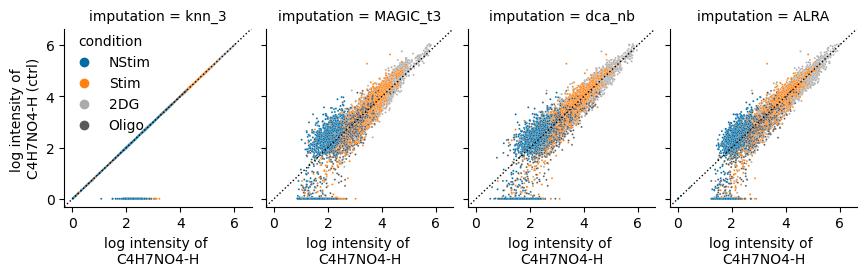

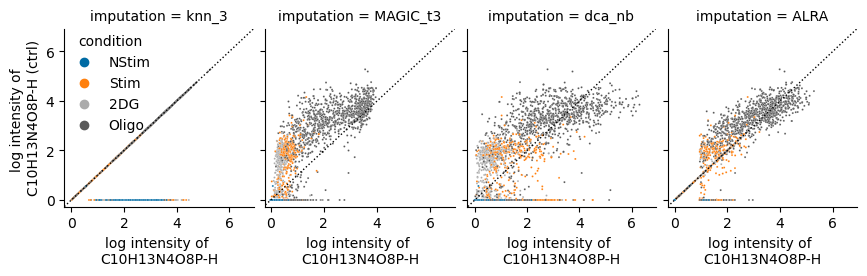

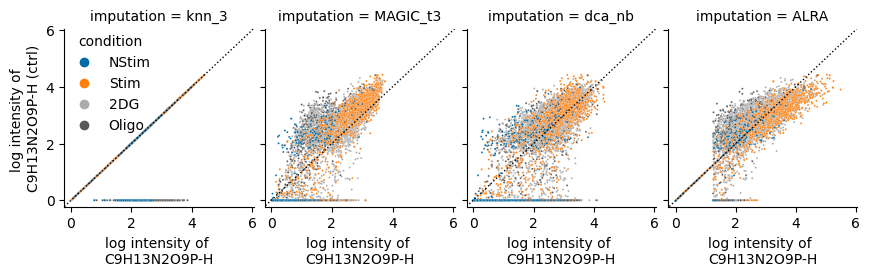

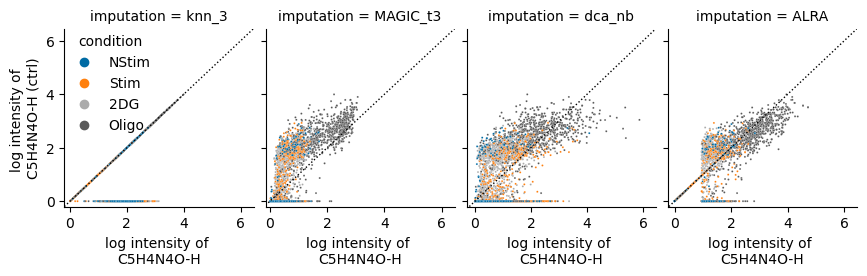

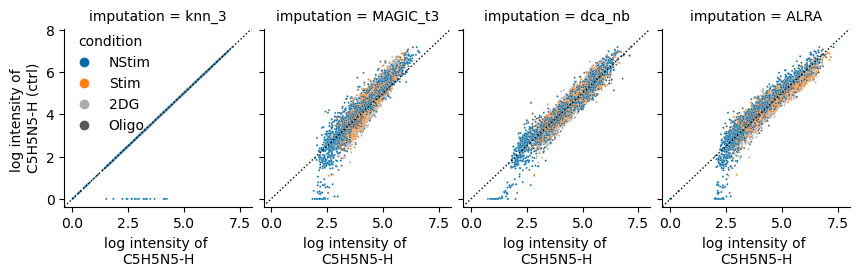

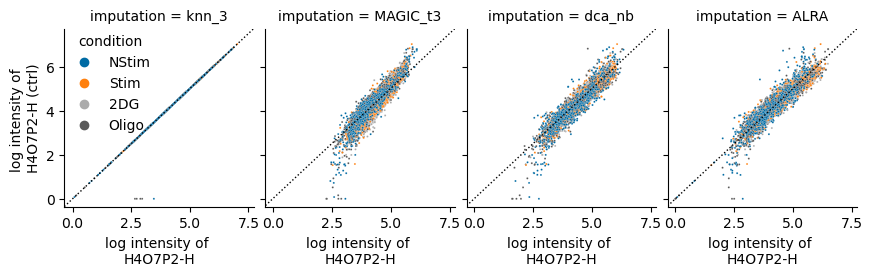

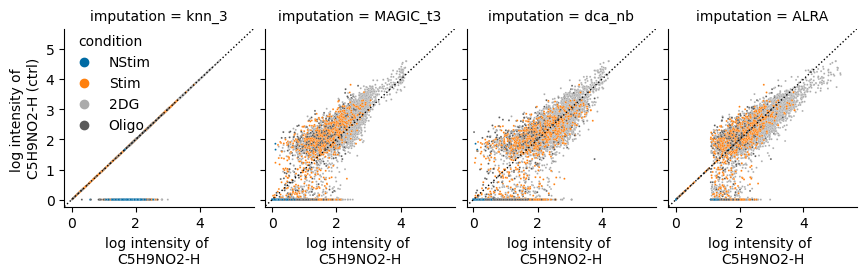

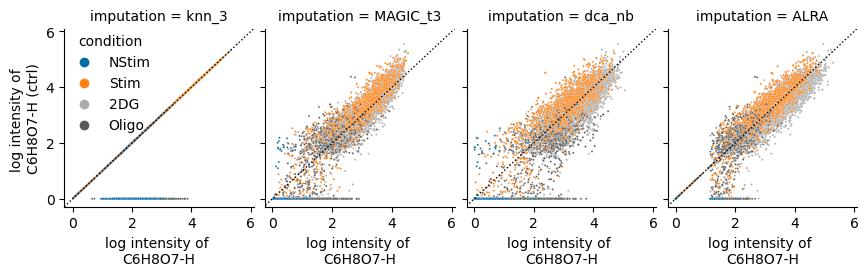

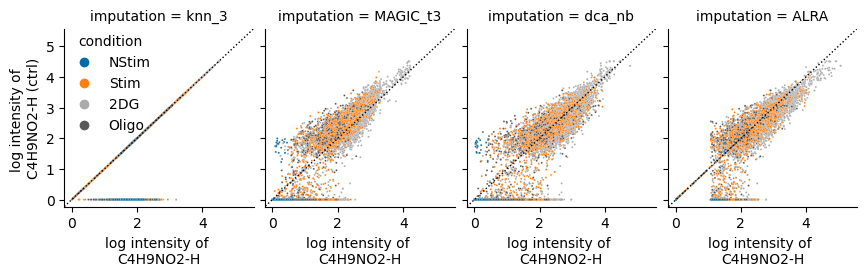

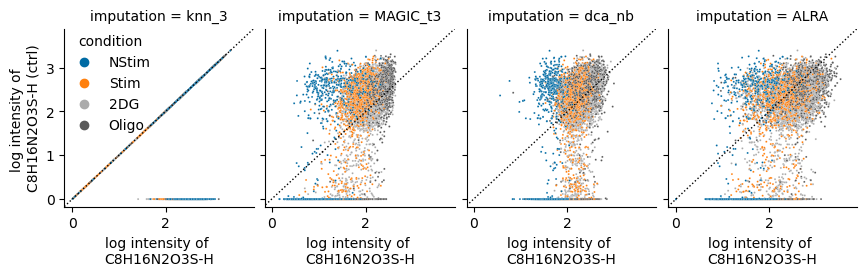

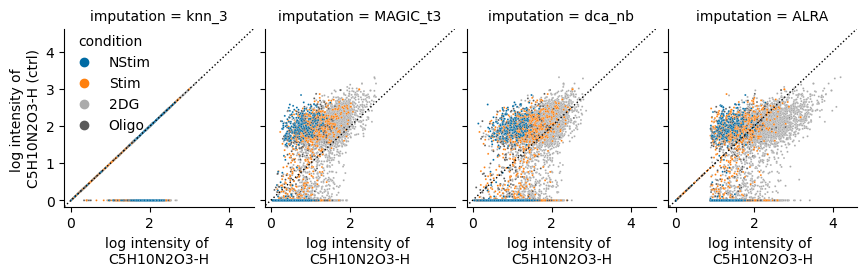

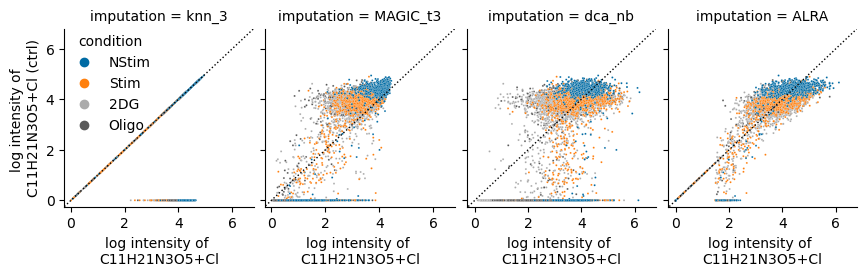

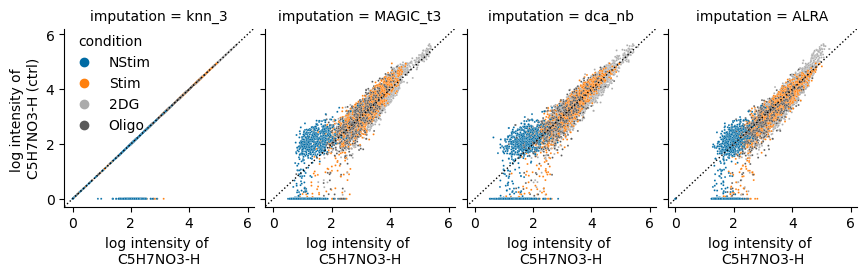

In [186]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')

for ion in ions:
    flat_ion_df = ion_df.copy()

    flat_ion_df = flat_ion_df.loc[:, flat_ion_df.columns.get_level_values(0).isin(['ctrl', 'knn_3', 'MAGIC_t3', 'ALRA', 'dca_nb', 'dca_zinb'])]
    flat_ion_df = flat_ion_df.loc[:, flat_ion_df.columns.get_level_values(1) == ion]
    flat_ion_df.columns = ["_".join(elem) for elem in (flat_ion_df.columns.to_flat_index())]
    max = flat_ion_df.max().max() * 1.1
    flat_ion_df = flat_ion_df.reset_index()
    fig = sns.pairplot(
        data=flat_ion_df, 
        hue='condition', hue_order=cond_order,
        plot_kws=dict(s=2), height=2.4, aspect=0.9,
        # x_vars = [i for i in flat_ion_df.columns if not i.startswith('ctrl') and i.endswith(ion)],
        #x_vars = [f"{i}_{ion}" for i in ['knn_3', 'ALRA', 'MAGIC_t3', 'dca_nb', 'dca_zinb']],
        x_vars = [f"{i}_{ion}" for i in ['knn_3', 'MAGIC_t3', 'dca_nb',  'ALRA']],
        y_vars = [i for i in flat_ion_df.columns if i.startswith('ctrl')],
    )

    fig.axes.flat[0].set_ylabel(f'log intensity of \n{ion} (ctrl)')
    for ax in fig.axes.flat:
        ax.set_title('imputation = ' + "_".join(ax.get_xlabel().split('_')[:-1]), size=10)
        ax.set_xlabel('log intensity of \n' + ax.get_xlabel().split('_')[-1])
        ax.axline((0, 0), slope=1, color='black', linestyle='dotted', linewidth=1)
        ax.set_xlim(ax.get_xlim()[0], max)
        ax.set_ylim(ax.get_ylim()[0], max)

    sns.move_legend(fig, 'upper left', bbox_to_anchor=(0.05, 0.99), ncol=1)
    fig.savefig(f'/home/mklein/Dropouts/ion_evaluation/Seahorse_{ion}_pairplot.pdf')
    fig.savefig(f'/home/mklein/Dropouts/ion_evaluation/Seahorse_{ion}_pairplot.png')


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


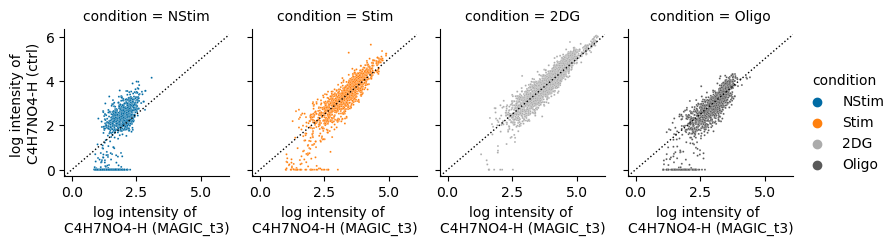

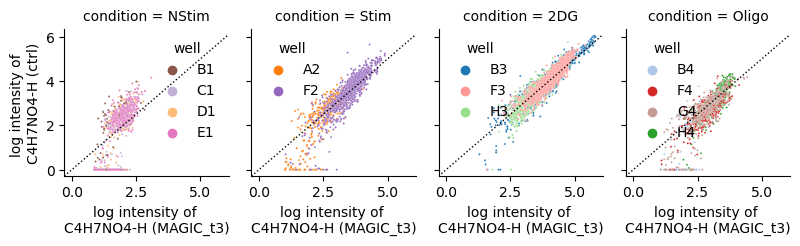

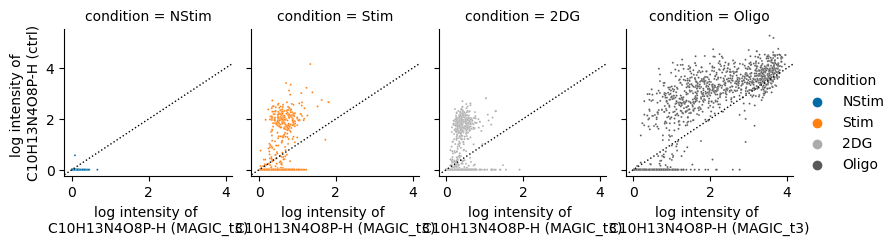

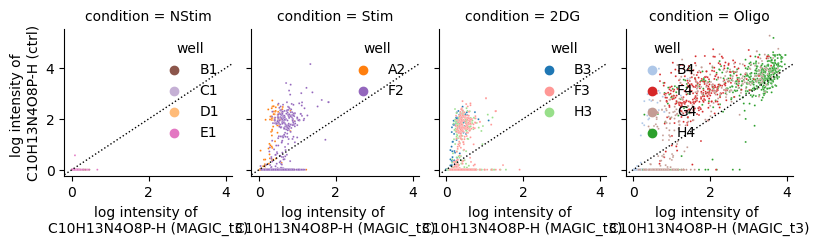

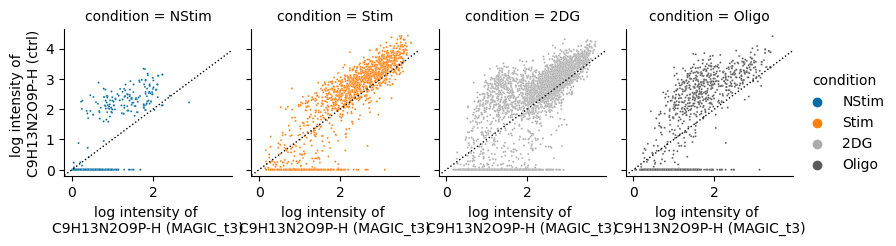

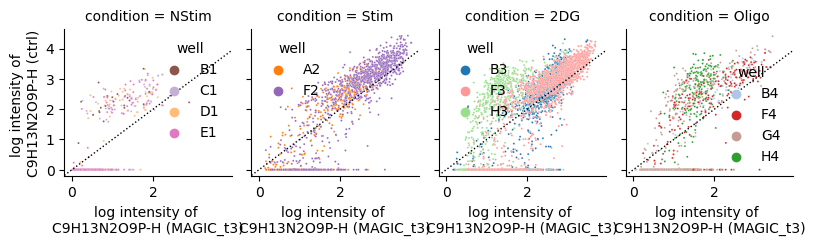

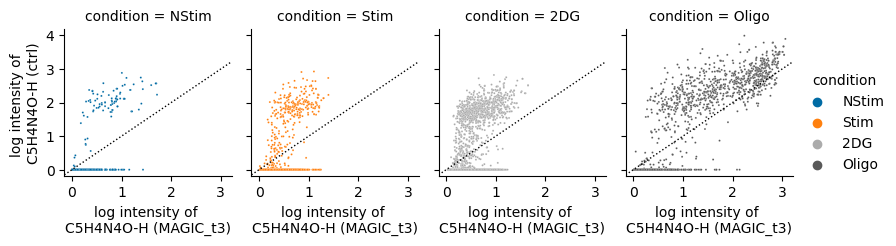

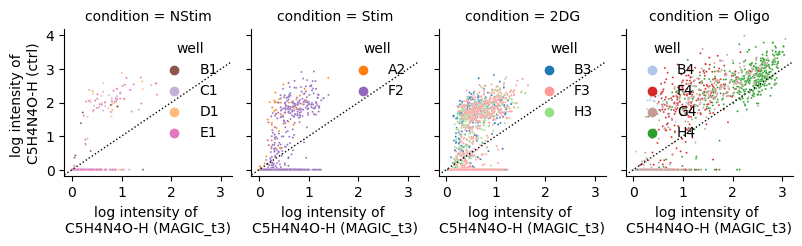

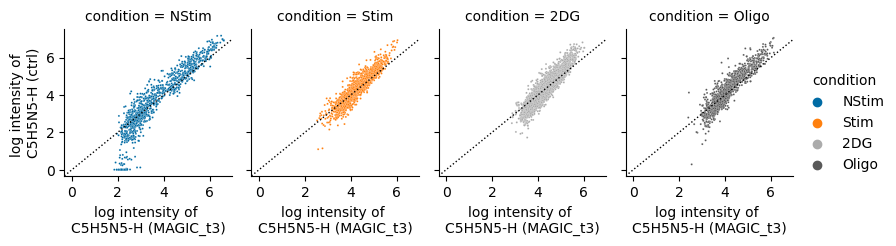

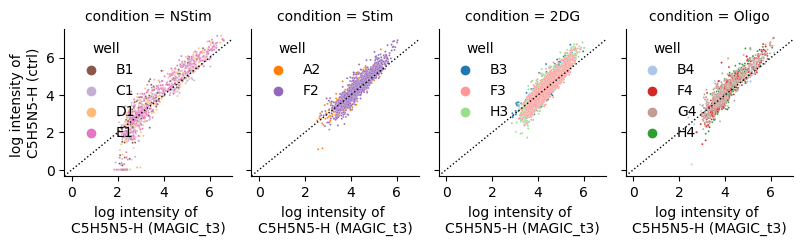

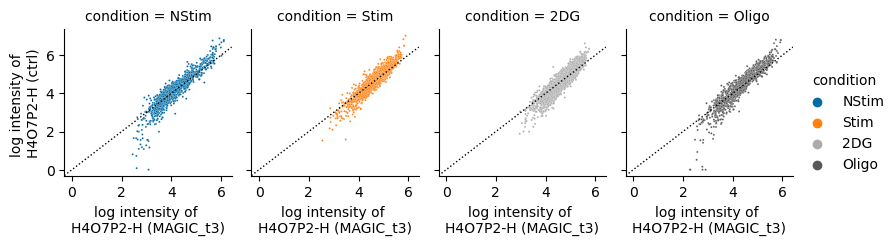

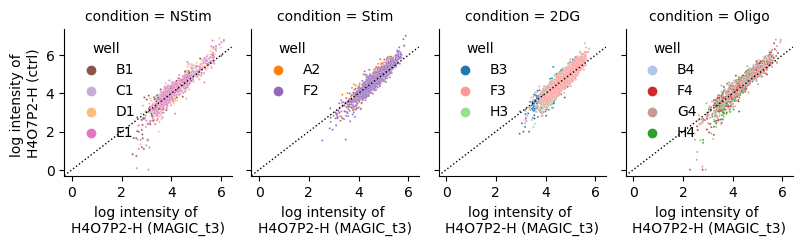

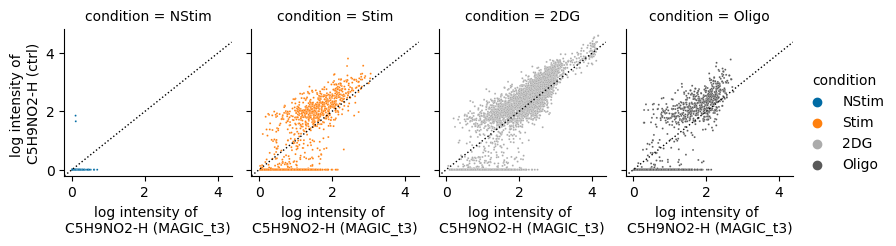

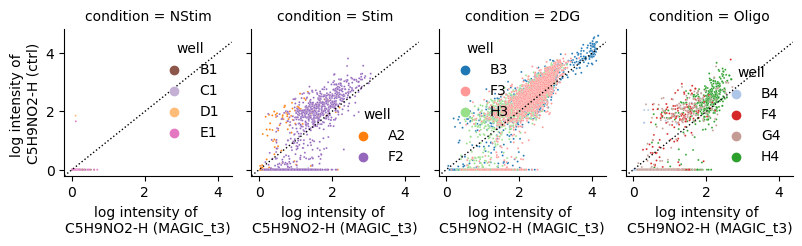

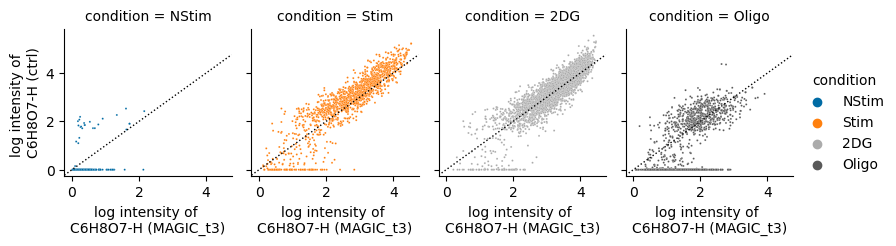

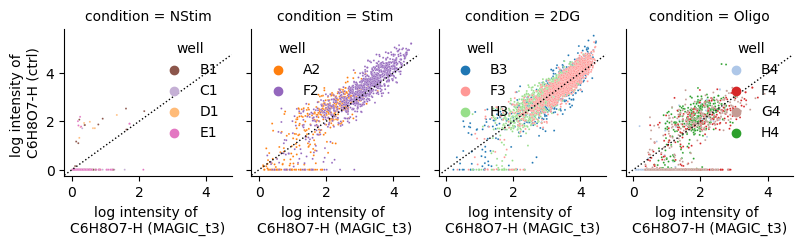

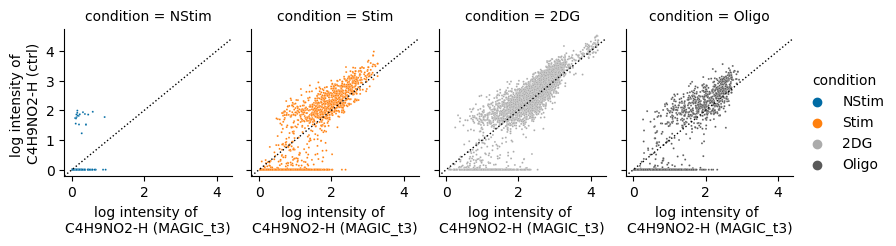

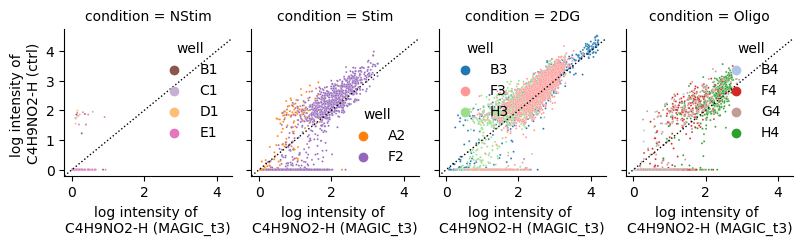

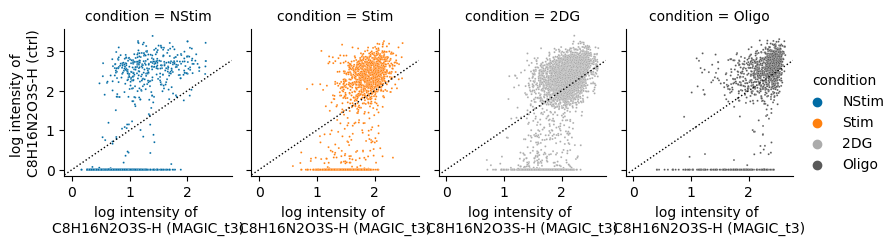

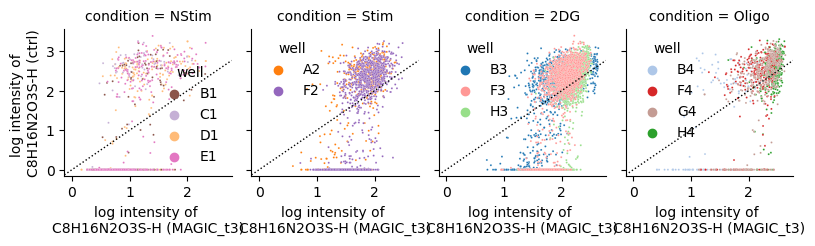

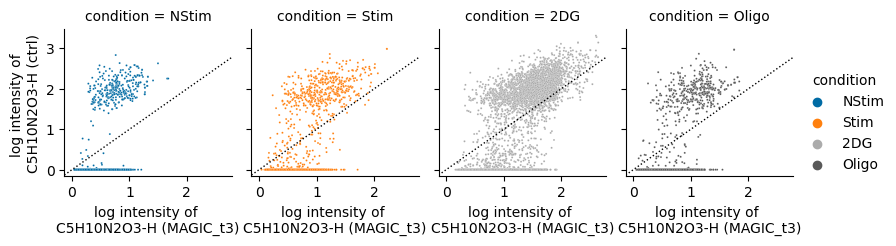

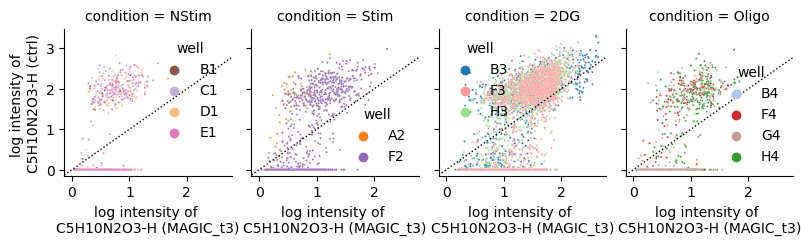

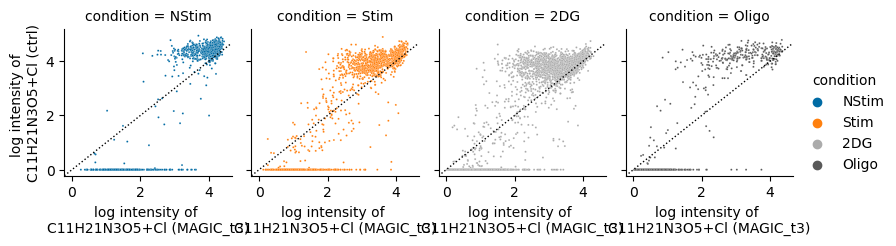

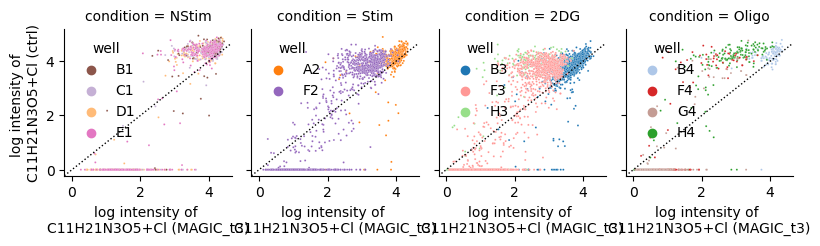

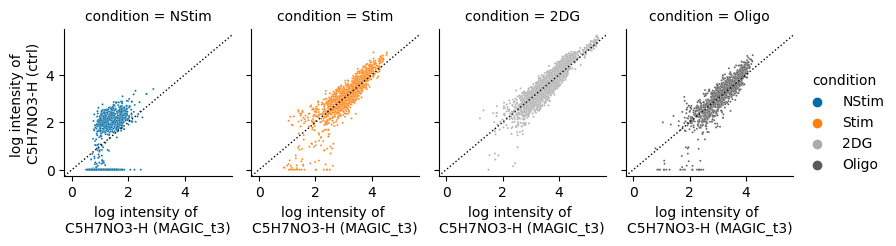

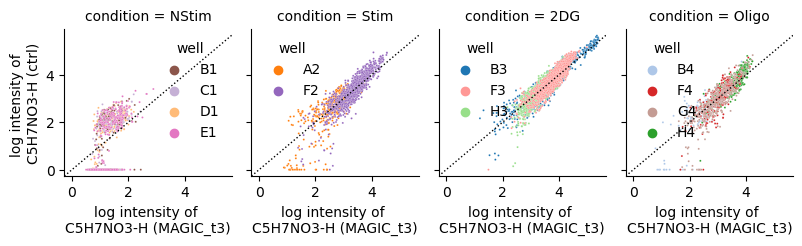

In [187]:
i_df = ion_df.copy()
i_df['well'] = i_df.index.get_level_values('sample')
i_df = i_df.set_index('well', append=True)
i_df.columns = ["_".join(elem) for elem in (i_df.columns.to_flat_index())]
i = 'C5H9NO2-H'# analysis_ions[4]

sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')
for i in ions:
    cond_plot = sns.relplot(data=i_df, y=f'ctrl_{i}', x=f'MAGIC_t3_{i}', hue='condition', s=2, col='condition', height=2.4, hue_order=cond_order, col_order=cond_order, aspect=0.83)
    cond_plot.axes.flat[0].set_ylabel(f'log intensity of \n{i} (ctrl)')
    for ax in cond_plot.axes.flat:
        ax.set_xlabel(f"log intensity of \n{ax.get_xlabel().split('_')[-1]} ({'_'.join(ax.get_xlabel().split('_')[:-1])})")
        ax.axline((0, 0), slope=1, color='black', linestyle='dotted', linewidth=1)
    cond_plot.savefig(f'/home/mklein/Dropouts/ion_evaluation/Seahorse_{i}_cond_plot.pdf')
    cond_plot.savefig(f'/home/mklein/Dropouts/ion_evaluation/Seahorse_{i}_cond_plot.png')
    
    
    well_plot = sns.relplot(
        data=i_df, y=f'ctrl_{i}', x=f'MAGIC_t3_{i}', 
        hue='well', s=2, col='condition', height=2.4, aspect=0.83,
        col_order=cond_order, 
        palette='tab20', facet_kws=dict(legend_out=False))
    well_plot.axes.flat[0].set_ylabel(f'log intensity of \n{i} (ctrl)')
    handles, labels = well_plot.axes.flat[0].get_legend_handles_labels()
    colors = [handle.get_facecolor()[0] for handle in handles]
    legend = dict(zip(labels, handles))

    for (row, col, hue), data in well_plot.facet_data():

        ax = well_plot.facet_axis(row, col)
        present_legend = list(set(legend.keys()).intersection(data['well'].unique()))
        present_legend.sort()
        ax.legend(handles=[legend[key] for key in present_legend], labels=present_legend, frameon=False, title='well')
        ax.set_xlabel(f"log intensity of \n{ax.get_xlabel().split('_')[-1]} ({'_'.join(ax.get_xlabel().split('_')[:-1])})")
        ax.axline((0, 0), slope=1, color='black', linestyle='dotted', linewidth=1)

    #sns.move_legend(well_plot, bbox_to_anchor=(0.5, 1), loc='lower center', ncol=len(i_df.index.get_level_values('well').unique()), frameon=False)
    well_plot.savefig(f'/home/mklein/Dropouts/ion_evaluation/Seahorse_{i}_well_plot.pdf')
    well_plot.savefig(f'/home/mklein/Dropouts/ion_evaluation/Seahorse_{i}_well_plot.png')


In [23]:
long_ion_df = ion_df.reset_index().melt(
    id_vars=["cell_id", "condition", "sample"], var_name=["layer", "ion"]
)
long_ion_df = long_ion_df.loc[~long_ion_df["layer"].isin(exclude_imps)]
long_ion_df["imputation"] = long_ion_df["layer"]
long_ion_df["group"] = list(
    long_ion_df["imputation"].apply(lambda x: re.sub("_[^_]+$", "", x))
)
long_ion_df["ctrl"] = [
    "ctrl" if c == "ctrl" else "imputation" for c in long_ion_df["group"]
]
long_ion_df

cell_id condition sample        layer        ion     value  \
0          160_B3       2DG     B3         ctrl  C4H7NO4-H  3.858573   
1          161_B3       2DG     B3         ctrl  C4H7NO4-H  4.413191   
2          162_B3       2DG     B3         ctrl  C4H7NO4-H  4.374252   
3          165_B3       2DG     B3         ctrl  C4H7NO4-H  3.251326   
4          166_B3       2DG     B3         ctrl  C4H7NO4-H  4.586231   
...           ...       ...    ...          ...        ...       ...   
2060755  10324_E1     NStim     E1  fancy_multi  C5H7NO3-H  1.919225   
2060756  10329_E1     NStim     E1  fancy_multi  C5H7NO3-H  2.098237   
2060757  10334_E1     NStim     E1  fancy_multi  C5H7NO3-H  2.200783   
2060758  10336_E1     NStim     E1  fancy_multi  C5H7NO3-H  1.864258   
2060759  10340_E1     NStim     E1  fancy_multi  C5H7NO3-H  2.277041   

          imputation  group        ctrl  
0               ctrl   ctrl        ctrl  
1               ctrl   ctrl        ctrl  
2               ctrl   ctrl        ctrl  
3               ctrl   ctrl        ctrl  
4               ctrl   ctrl        ctrl  
...              ...    ...         ...  
2060755  fancy_multi  fancy  imputation  
2060756  fancy_multi  fancy  imputation  
2060757  fancy_multi  fancy  imputation  
2060758  fancy_multi  fancy  imputation  
2060759  fancy_multi  fancy  imputation  

[1236456 rows x 9 columns]

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decoration

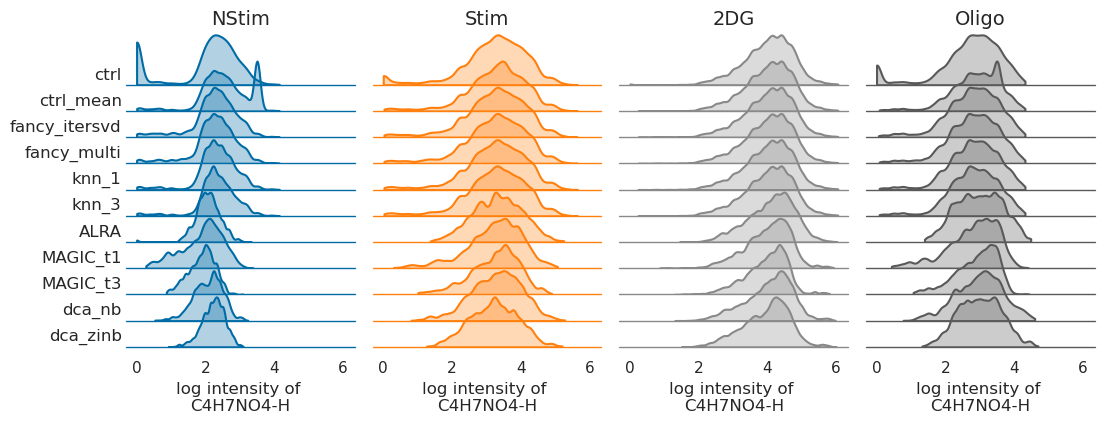

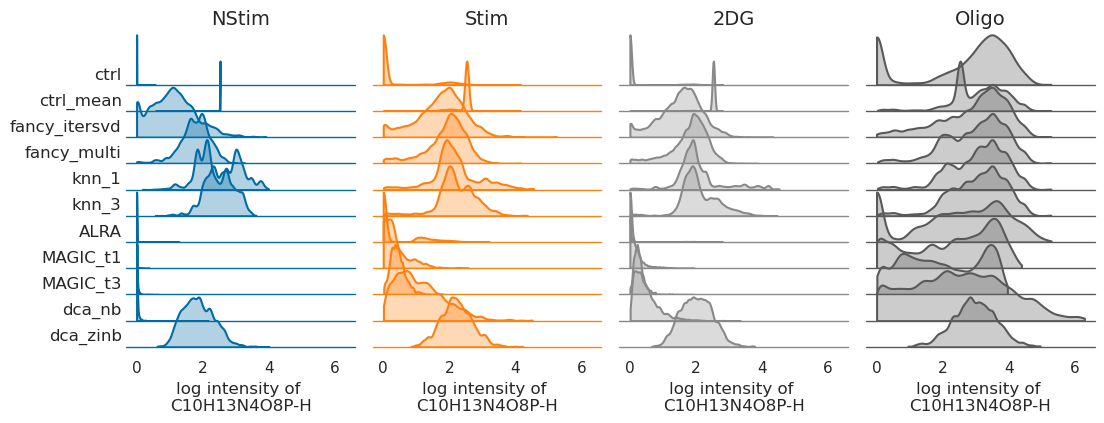

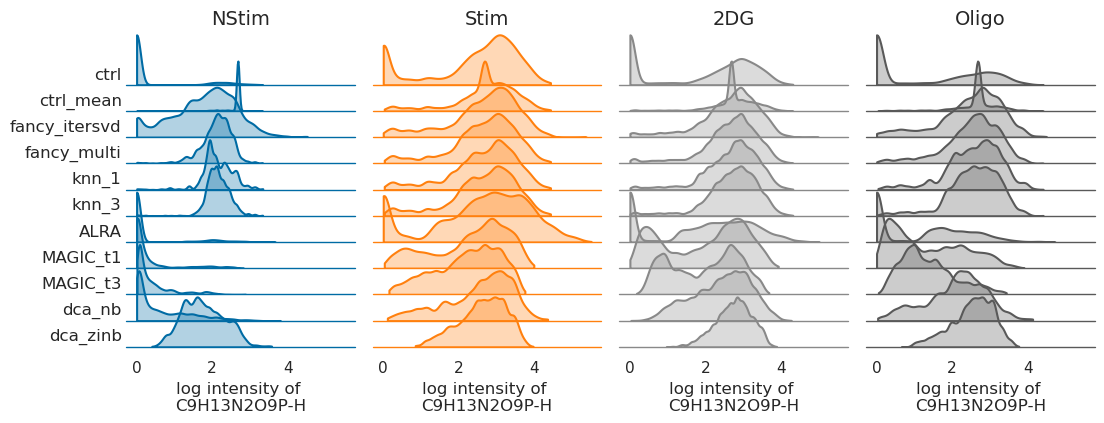

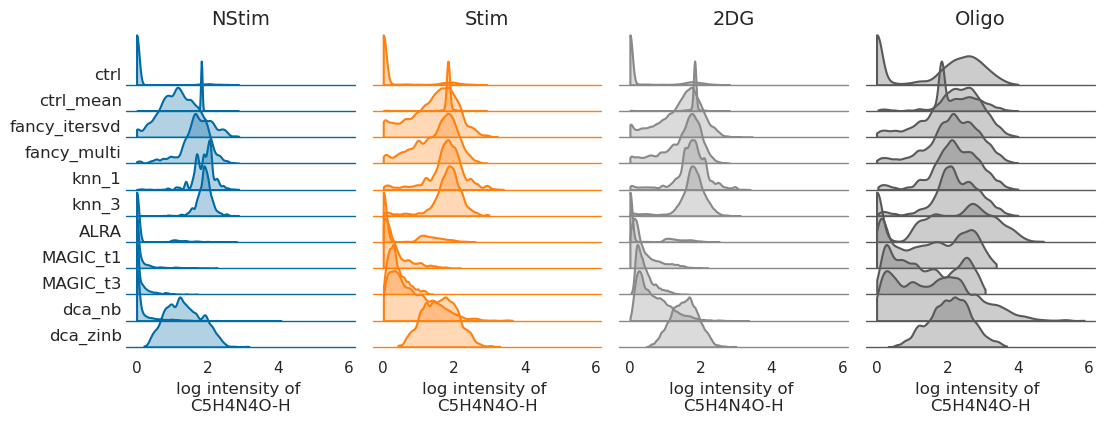

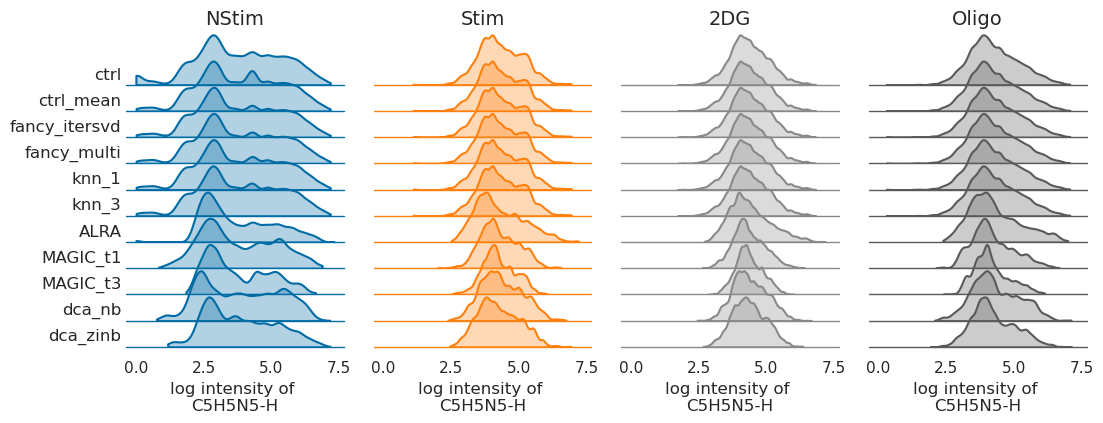

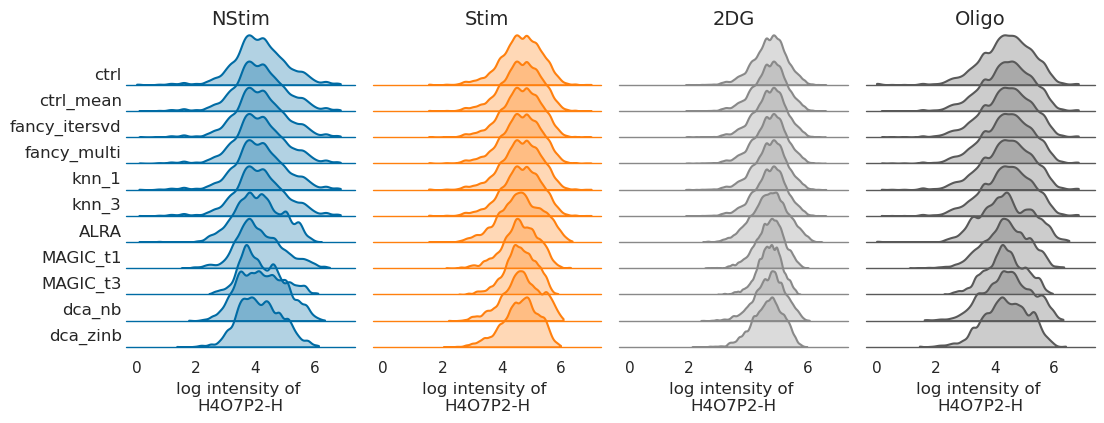

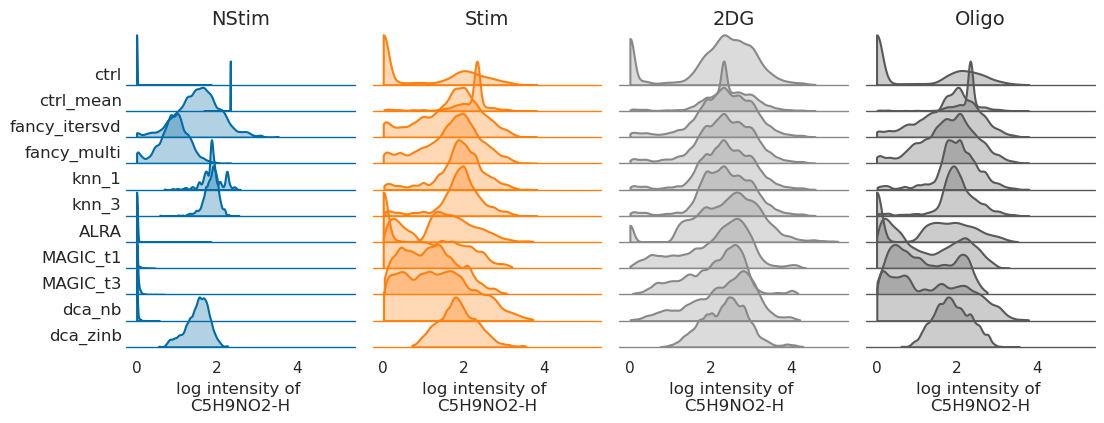

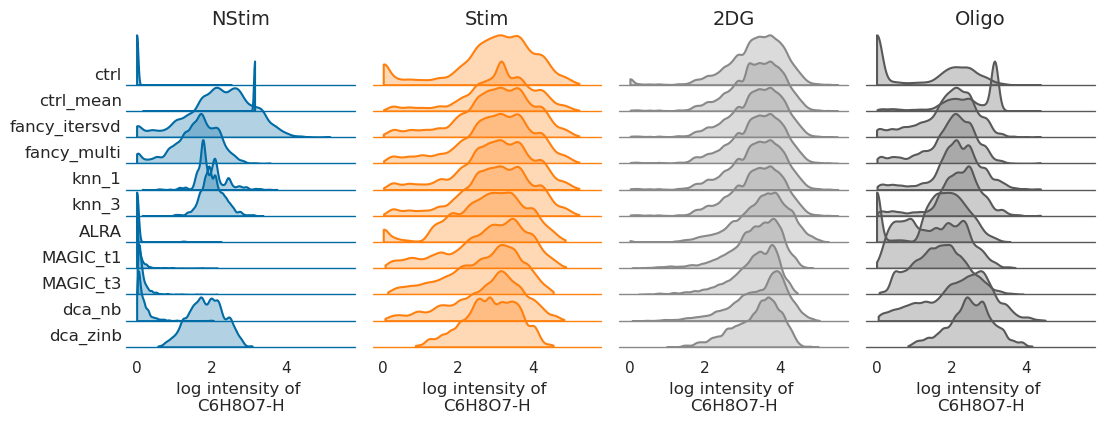

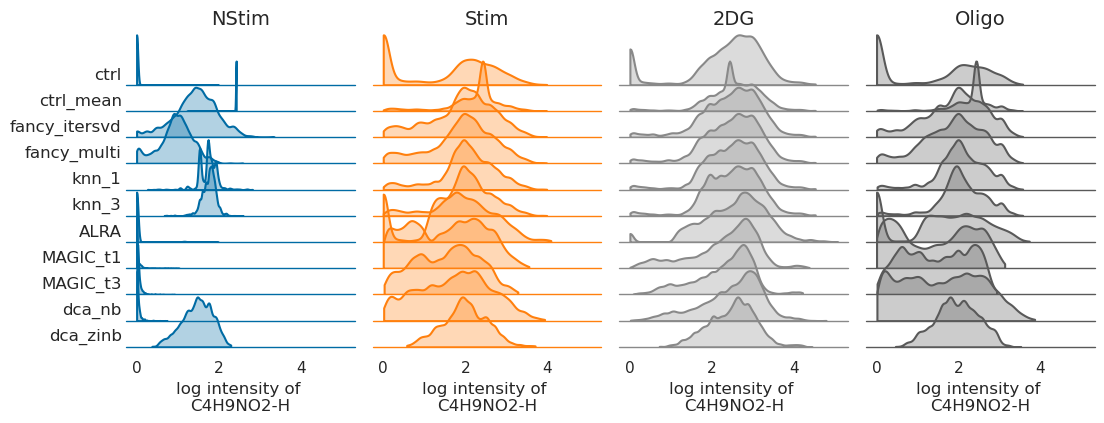

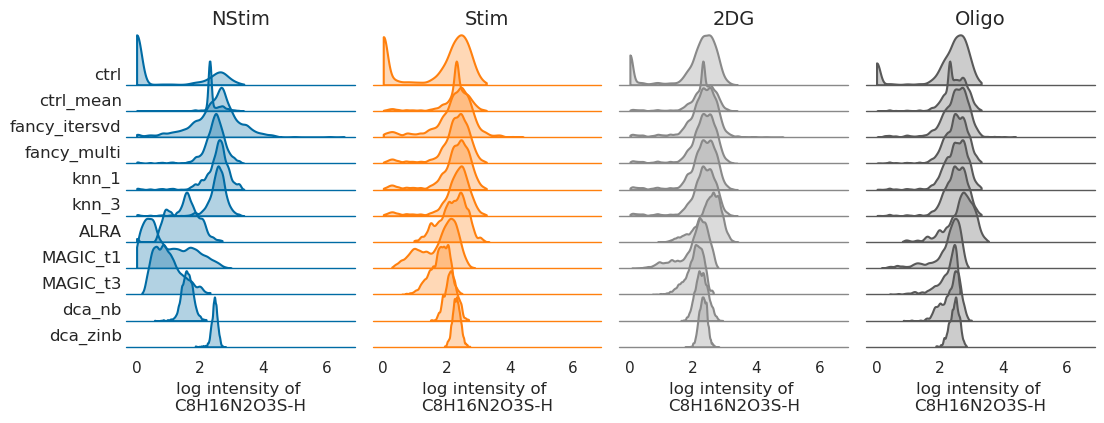

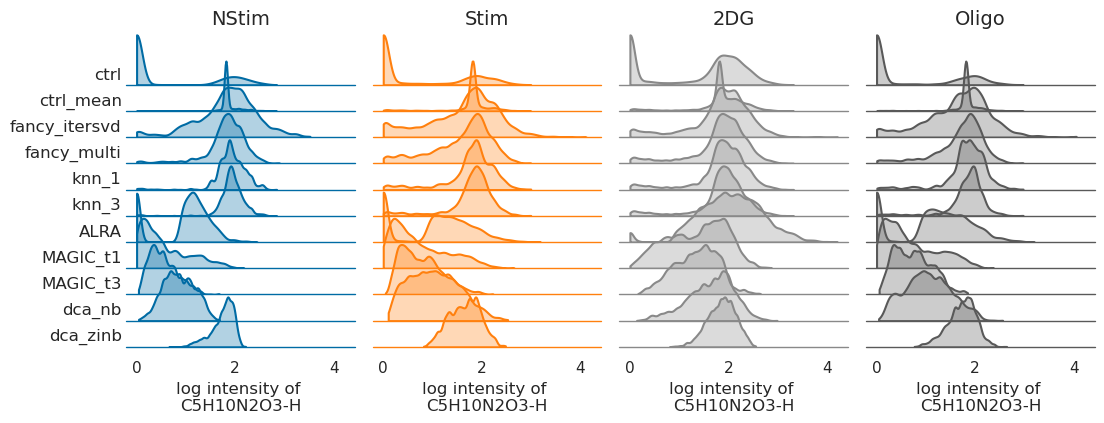

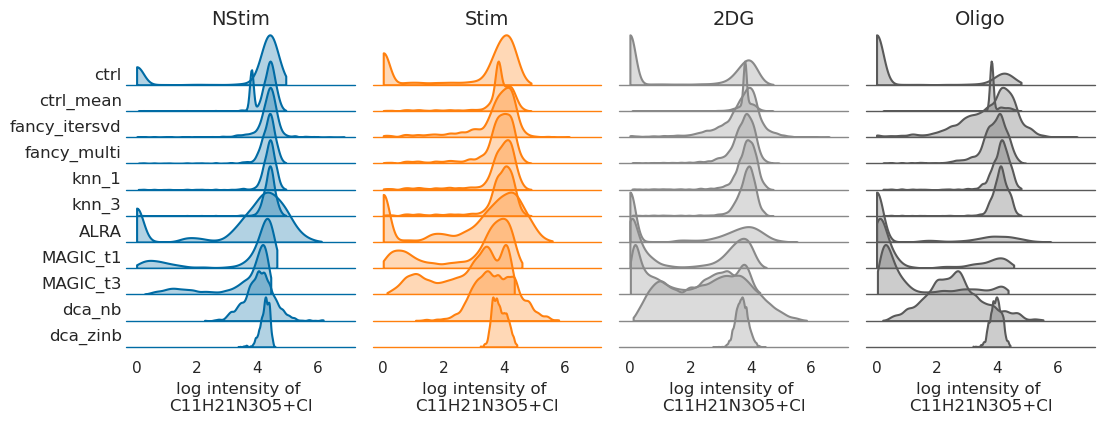

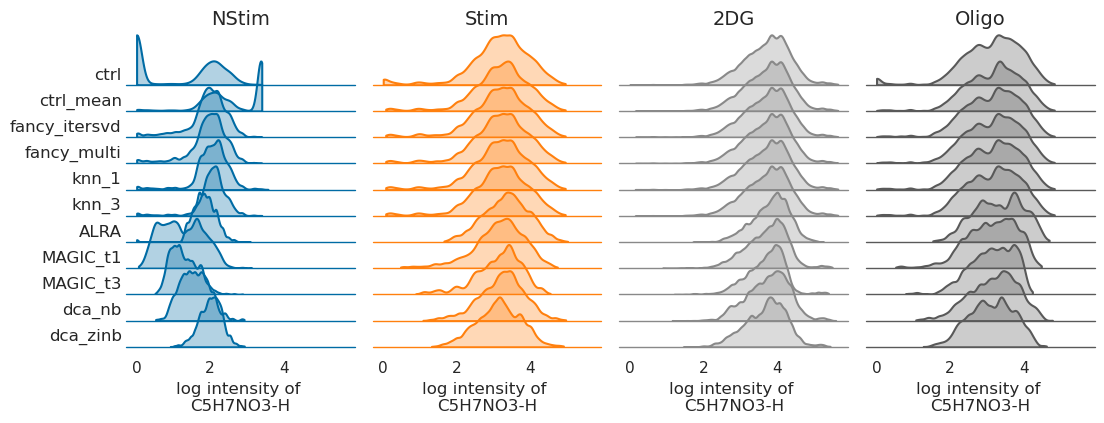

In [192]:
# sns.set_theme(style="white")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.style.use("tableau-colorblind10")

for i in ions:
    g = sns.FacetGrid(
        long_ion_df[long_ion_df["ion"] == i].sort_values(["ctrl", "group"]),
        hue="condition",
        row="layer",
        row_order=[
            "ctrl",
            "ctrl_mean",
            "fancy_itersvd",
            "fancy_multi",
            "knn_1",
            "knn_3",
            "ALRA",
            "MAGIC_t1",
            "MAGIC_t3",
            "dca_nb",
            "dca_zinb",
        ],
        col="condition",
        col_order=cond_order,
        palette=["#898989", "#006BA4", "#595959", "#FF800E"],
        aspect=7,
        height=0.4,
        sharey=False,
    )

    # Draw the densities in a few steps
    g.map(
        sns.kdeplot,
        "value",
        bw_adjust=0.5,
        cut=0,
        clip_on=True,
        fill=True,
        alpha=0.3,
        linewidth=1.5,
    )
    # g.map(sns.kdeplot, "edge_weight", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
            size=14,
        )

    g.set_titles("")
    # g.map(label, "network_name")
    for j, ax in enumerate(g.axes[0]):
        ax.set_title(g.col_names[j], size=14)

    for j, row in enumerate(g.axes):
        row[0].text(
            -0.02,
            0.2,
            g.row_names[j],
            ha="right",
            va="center",
            transform=row[0].transAxes,
            size=12,
        )
    # Remove axes details that don't play well with overlap

    g.set_xlabels(f"log intensity of \n{i}", size=12)
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # g.add_legend()
    g.tight_layout()
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.5)

    g.figure.savefig(f"/home/mklein/Dropouts/ion_evaluation/Seahorse_{i}_kdeplot.pdf")
    g.figure.savefig(f"/home/mklein/Dropouts/ion_evaluation/Seahorse_{i}_kdeplot.png")

In [15]:
long_ion_df[long_ion_df["imputation"] == "ctrl"].groupby(["ion", "condition"])[
    ["value"]
].agg(lambda x: len(x[x == 0]) / len(x))

value
ion           condition          
C10H13N4O8P-H 2DG        0.896443
              NStim      0.999102
              Oligo      0.197092
              Stim       0.791956
C11H21N3O5+Cl 2DG        0.485604
              NStim      0.210243
              Oligo      0.714055
              Stim       0.227462
C4H7NO4-H     2DG        0.001694
              NStim      0.172507
              Oligo      0.058966
              Stim       0.021498
C4H9NO2-H     2DG        0.092911
              NStim      0.982929
              Oligo      0.374798
              Stim       0.291956
C5H10N2O3-H   2DG        0.263973
              NStim      0.689128
              Oligo      0.624394
              Stim       0.577670
C5H4N4O-H     2DG        0.746189
              NStim      0.916442
              Oligo      0.289176
              Stim       0.781553
C5H5N5-H      2DG        0.000000
              NStim      0.020665
              Oligo      0.000000
              Stim       0.000000
C5H7NO3-H     2DG        0.000242
              NStim      0.410602
              Oligo      0.015347
              Stim       0.012483
C5H9NO2-H     2DG        0.123639
              NStim      0.998203
              Oligo      0.478998
              Stim       0.456311
C6H8O7-H      2DG        0.012098
              NStim      0.977538
              Oligo      0.390145
              Stim       0.053398
C8H16N2O3S-H  2DG        0.109848
              NStim      0.618149
              Oligo      0.113086
              Stim       0.221914
C9H13N2O9P-H  2DG        0.291556
              NStim      0.839173
              Oligo      0.483037
              Stim       0.133842
H4O7P2-H      2DG        0.000000
              NStim      0.000898
              Oligo      0.003231
              Stim       0.000000

In [24]:
all_imp_compare_df = long_ion_df.pivot(
    index=["cell_id", "condition", "sample", "ion"],
    columns=["imputation"],
    values="value",
)
all_imp_compare_df

imputation                                   ALRA  MAGIC_t1  MAGIC_t2  \
cell_id  condition sample ion                                           
10000_E1 NStim     E1     C10H13N4O8P-H  0.000000  0.000000  0.000000   
                          C11H21N3O5+Cl  3.702439  4.378975  4.206572   
                          C4H7NO4-H      2.051473  1.893162  1.912413   
                          C4H9NO2-H      0.000000  0.083943  0.057271   
                          C5H10N2O3-H    1.409294  1.400669  1.036602   
...                                           ...       ...       ...   
999_B3   2DG       B3     C5H9NO2-H      2.939022  2.792047  2.765984   
                          C6H8O7-H       4.315151  3.975559  3.810225   
                          C8H16N2O3S-H   2.457277  1.781514  1.862576   
                          C9H13N2O9P-H   3.552891  3.108207  2.939754   
                          H4O7P2-H       4.974369  4.894865  4.825491   

imputation                               MAGIC_t3      ctrl  ctrl_mean  \
cell_id  condition sample ion                                            
10000_E1 NStim     E1     C10H13N4O8P-H  0.003817  0.000000   2.527191   
                          C11H21N3O5+Cl  4.098519  4.519272   4.519272   
                          C4H7NO4-H      1.971594  2.028445   2.028445   
                          C4H9NO2-H      0.053186  0.000000   2.427666   
                          C5H10N2O3-H    0.884752  2.018815   2.018815   
...                                           ...       ...        ...   
999_B3   2DG       B3     C5H9NO2-H      2.718463  2.636312   2.636312   
                          C6H8O7-H       3.742760  4.341975   4.341975   
                          C8H16N2O3S-H   1.881952  1.767222   1.767222   
                          C9H13N2O9P-H   2.856160  3.434275   3.434275   
                          H4O7P2-H       4.794501  5.101246   5.101246   

imputation                                 dca_nb  dca_zinb  fancy_itersvd  \
cell_id  condition sample ion                                                
10000_E1 NStim     E1     C10H13N4O8P-H  0.003206  2.697321       1.639421   
                          C11H21N3O5+Cl  3.649431  4.161505       4.519272   
                          C4H7NO4-H      2.112282  2.178270       2.028445   
                          C4H9NO2-H      0.007780  1.779467       1.922494   
                          C5H10N2O3-H    1.449939  1.984427       2.018815   
...                                           ...       ...            ...   
999_B3   2DG       B3     C5H9NO2-H      2.928321  2.742744       2.636312   
                          C6H8O7-H       4.208194  3.830620       4.341975   
                          C8H16N2O3S-H   2.192711  2.330212       1.767222   
                          C9H13N2O9P-H   3.135501  2.886786       3.434275   
                          H4O7P2-H       4.984690  4.806092       5.101246   

imputation                               fancy_multi     knn_3     knn_5  
cell_id  condition sample ion                                             
10000_E1 NStim     E1     C10H13N4O8P-H     2.256744  2.732434  2.765740  
                          C11H21N3O5+Cl     4.519272  4.519272  4.519272  
                          C4H7NO4-H         2.028445  2.028445  2.028445  
                          C4H9NO2-H         1.272778  1.933169  1.968624  
                          C5H10N2O3-H       2.018815  2.018815  2.018815  
...                                              ...       ...       ...  
999_B3   2DG       B3     C5H9NO2-H         2.636312  2.636312  2.636312  
                          C6H8O7-H          4.341975  4.341975  4.341975  
                          C8H16N2O3S-H      1.767222  1.767222  1.767222  
                          C9H13N2O9P-H      3.434275  3.434275  3.434275  
                          H4O7P2-H          5.101246  5.101246  5.101246  

[103038 rows x 12 columns]

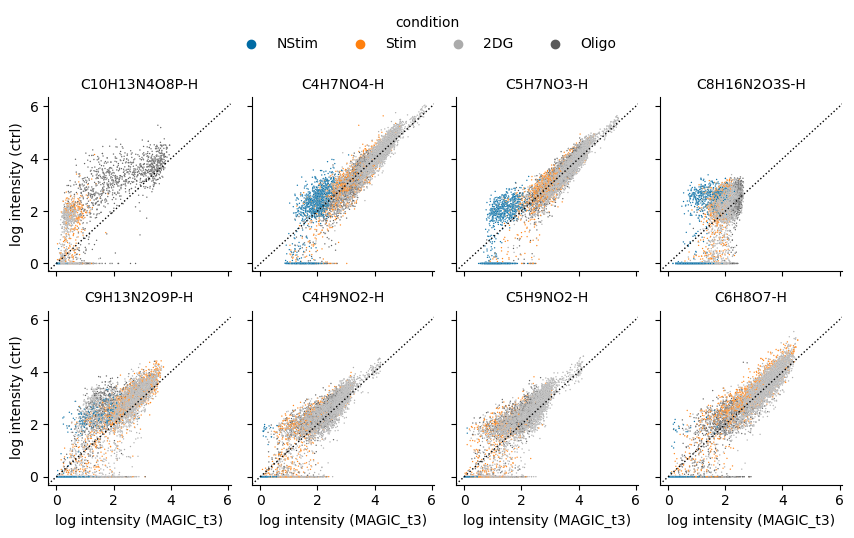

In [25]:
other_ion_plot = sns.relplot(
    data=all_imp_compare_df,
    y="ctrl",
    x="MAGIC_t3",
    hue="condition",
    hue_order=cond_order,
    s=1,
    height=2.4,
    aspect=0.9,
    col="ion",
    col_order=[
        "C10H13N4O8P-H",
        "C4H7NO4-H",
        "C5H7NO3-H",
        "C8H16N2O3S-H",
        "C9H13N2O9P-H",
        "C4H9NO2-H",
        "C5H9NO2-H",
        "C6H8O7-H",
    ],
    col_wrap=4,
    facet_kws=dict(legend_out=False),
)

other_ion_plot.set_xlabels(f"log intensity (MAGIC_t3)")
other_ion_plot.set_ylabels(f"log intensity (ctrl)")
for ax in other_ion_plot.axes.flat:
    ax.axline((0, 0), slope=1, color="black", linestyle="dotted", linewidth=1)

other_ion_plot.set_titles("{col_name}")
sns.move_legend(
    other_ion_plot, bbox_to_anchor=(0.5, 1), loc="lower center", ncol=4, frameon=False
)
other_ion_plot.tight_layout()
other_ion_plot.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/Seahorse_other_ion_plot.pdf"
)

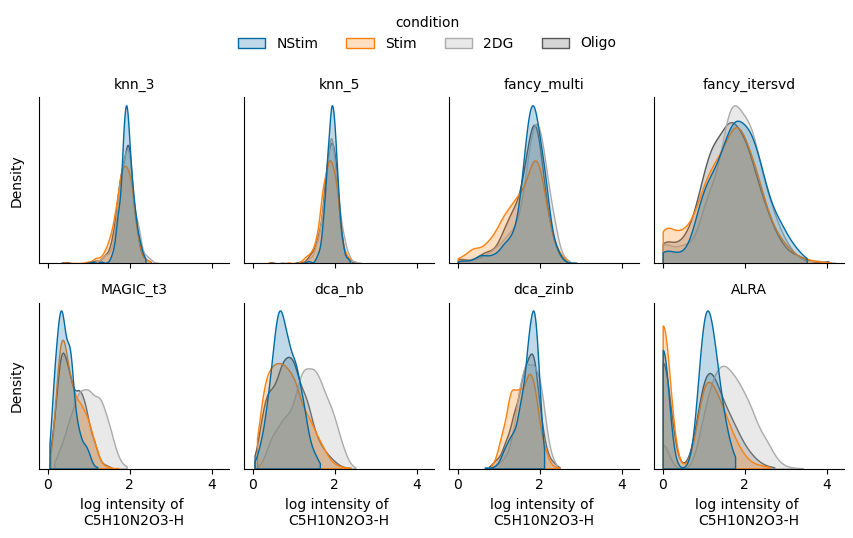

In [28]:
kde_fill_plot = sns.displot(
    data=all_imp_compare_df[
        (all_imp_compare_df["ctrl"] == 0)
        & (all_imp_compare_df.index.get_level_values("ion") == "C5H10N2O3-H")
    ].melt(ignore_index=False),
    x="value",
    hue="condition",
    col="imputation",
    common_norm=False,
    col_order=[
        "knn_3",
        "knn_5",
        "fancy_multi",
        "fancy_itersvd",
        "MAGIC_t3",
        "dca_nb",
        "dca_zinb",
        "ALRA",
    ],
    col_wrap=4,
    hue_order=cond_order,
    height=2.4,
    aspect=0.9,
    facet_kws=dict(legend_out=False, sharey=False),
    kind="kde",
    multiple="layer",
    fill=True,
    cut=0,
)

kde_fill_plot.set_titles("{col_name}")
kde_fill_plot.set_xlabels(f"log intensity of \nC5H10N2O3-H")

for ax in kde_fill_plot.axes.flat:
    ax.set_yticklabels([])
    ax.tick_params(left=False)
sns.move_legend(
    kde_fill_plot, bbox_to_anchor=(0.5, 1), loc="lower center", ncol=4, frameon=False
)
kde_fill_plot.tight_layout()

kde_fill_plot.savefig(
    f"/home/mklein/Dropouts/ion_evaluation/Seahorse_kde_fill_plot.pdf"
)

In [45]:
# rel_zero_imp = long_ion_df[(long_ion_df['layer'].isin(['ctrl', 'MAGIC_t3'])) & (long_ion_df['ion'] == "C4H7NO4+Cl")].copy()
# rel_zero_imp = long_ion_df[(long_ion_df['ion'] == "C4H7NO4+Cl")].copy()
ions = adata.var_names
ion_df_list = []
for layer in ["ctrl", "knn_3", "MAGIC_t3", "ALRA", "dca_nb", "dca_zinb"]:
    # for layer in adata.layers.keys():
    df = pd.DataFrame(
        adata[:, ions].layers[layer],
        columns=pd.MultiIndex.from_tuples([(layer, ion) for ion in ions]),
        index=adata.obs_names,
    )
    ion_df_list.append(df)

ion_df = pd.concat(ion_df_list, axis=1)

ion_df = pd.merge(
    ion_df, adata.obs[["condition", "sample"]], left_index=True, right_index=True
).set_index(["condition", "sample"], append=True)
ion_df.columns = pd.MultiIndex.from_tuples(ion_df.columns)
long_ion_df = ion_df.reset_index().melt(
    id_vars=["cell_id", "condition", "sample"], var_name=["layer", "ion"]
)
rel_zero_imp = long_ion_df.copy()


# Define custom aggregation function
def fraction_nonzero(column):
    non_zero_count = (column != 0).sum()
    total_count = column.size
    return non_zero_count / total_count


zero_imp_df = (
    rel_zero_imp.groupby(["layer", "condition", "ion"])[["value"]]
    .agg(["mean", fraction_nonzero])
    .reset_index()
    .pivot(columns="layer", index=["condition", "ion"])
)
zero_imp_df.columns = zero_imp_df.columns.droplevel(0)
zero_imp_df.columns = ["_".join(elem) for elem in (zero_imp_df.columns.to_flat_index())]
long_zero_imp_df = (
    zero_imp_df[
        list(zero_imp_df.columns[zero_imp_df.columns.str.contains("mean")])
        + ["fraction_nonzero_ctrl"]
    ]
    .melt(
        id_vars=["fraction_nonzero_ctrl"],
        ignore_index=False,
        var_name="imputation",
        value_name="mean_intensity",
    )
    .reset_index()
)
long_zero_imp_df

/tmp/ipykernel_2123/790630512.py:12: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  ion_df = pd.merge(ion_df, adata.obs[['condition', 'sample']], left_index=True, right_index=True).set_index(['condition', 'sample'], append=True)


condition            ion  fraction_nonzero_ctrl  imputation  \
0          2DG    C10H10N2O-H               0.998548   mean_ALRA   
1          2DG   C10H10N2O2-H               0.999516   mean_ALRA   
2          2DG  C10H10N2O4S-H               0.997338   mean_ALRA   
3          2DG  C10H11N3O2S-H               0.127268   mean_ALRA   
4          2DG    C10H12N2O-H               0.467699   mean_ALRA   
...        ...            ...                    ...         ...   
8347      Stim       C9H9NO-H               0.945908  mean_knn_3   
8348      Stim      C9H9NO2-H               0.916089  mean_knn_3   
8349      Stim      C9H9NO3-H               0.266297  mean_knn_3   
8350      Stim     CH4NO5P+Cl               0.472954  mean_knn_3   
8351      Stim       H4O7P2-H               1.000000  mean_knn_3   

      mean_intensity  
0           4.640884  
1           3.008173  
2           2.822070  
3           0.357751  
4           1.640710  
...              ...  
8347        2.450338  
8348        2.342957  
8349        1.681288  
8350        1.719468  
8351        4.641960  

[8352 rows x 5 columns]

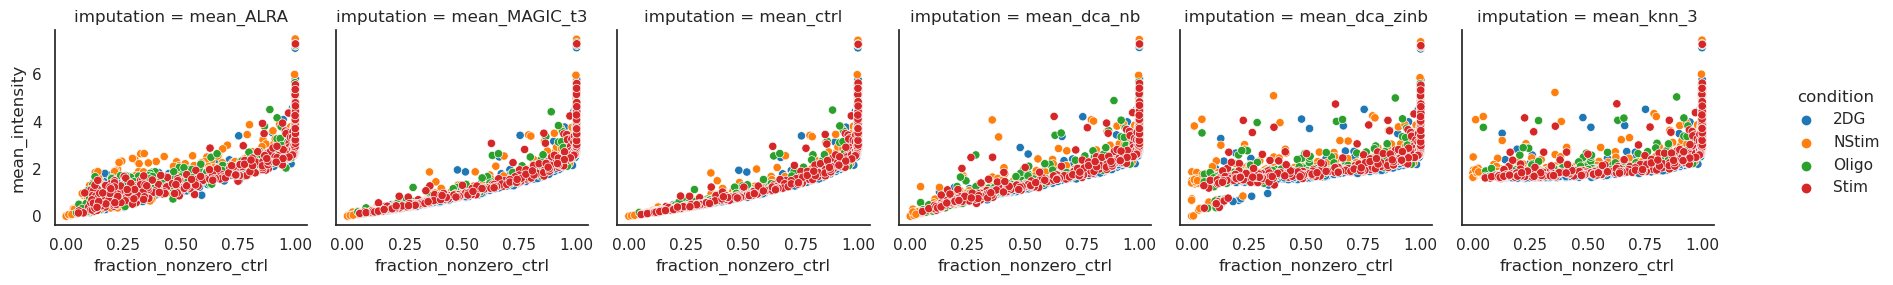

In [46]:
sns.relplot(
    data=long_zero_imp_df,
    x="fraction_nonzero_ctrl",
    y="mean_intensity",
    hue="condition",
    palette="tab10",
    col="imputation",
    height=3,
    facet_kws=dict(margin_titles=True),
)

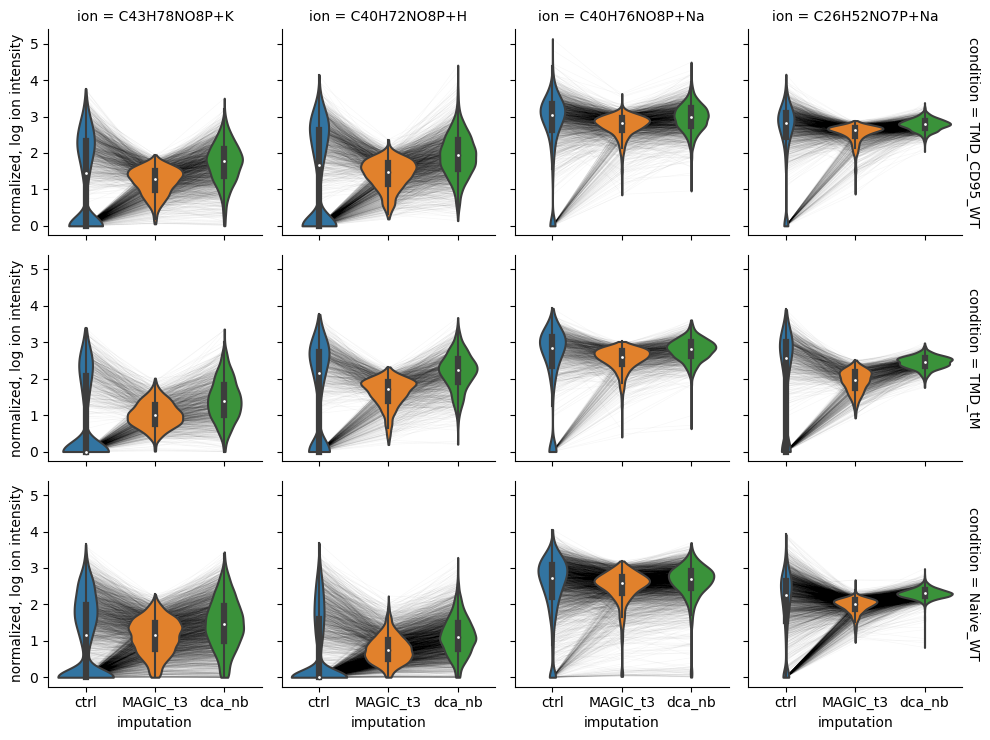

In [75]:
layers_direct_comp = ['ctrl', 'MAGIC_t3', 'dca_nb']

paired_plot = sns.catplot(
    data=long_ion_df[long_ion_df["layer"].isin(layers_direct_comp)].set_index(
        "cell_id"
    ),
    x="layer",
    x_order=layers_direct_comp,
    row="condition",
    col="ion",
    y="value",
    alpha=0.2,
    kind="violin",
    cut=0,
    sharey=True,
    margin_titles=True,
    height=2.5,
)

for (row, col, hue), data_table in list(paired_plot.facet_data()):
    wide_df = data_table.reset_index().pivot(
        columns="layer", index=["cell_id"], values="value"
    )
    for i in wide_df.index:
        paired_plot.axes[row][col].plot(
            list(range(len(wide_df.columns))),
            wide_df.loc[i, layers_direct_comp],
            color="black",
            linewidth=0.5,
            alpha=0.03,
            zorder=-1,
        )

paired_plot.set_ylabels("normalized, log ion intensity")
paired_plot.set_xlabels("imputation")

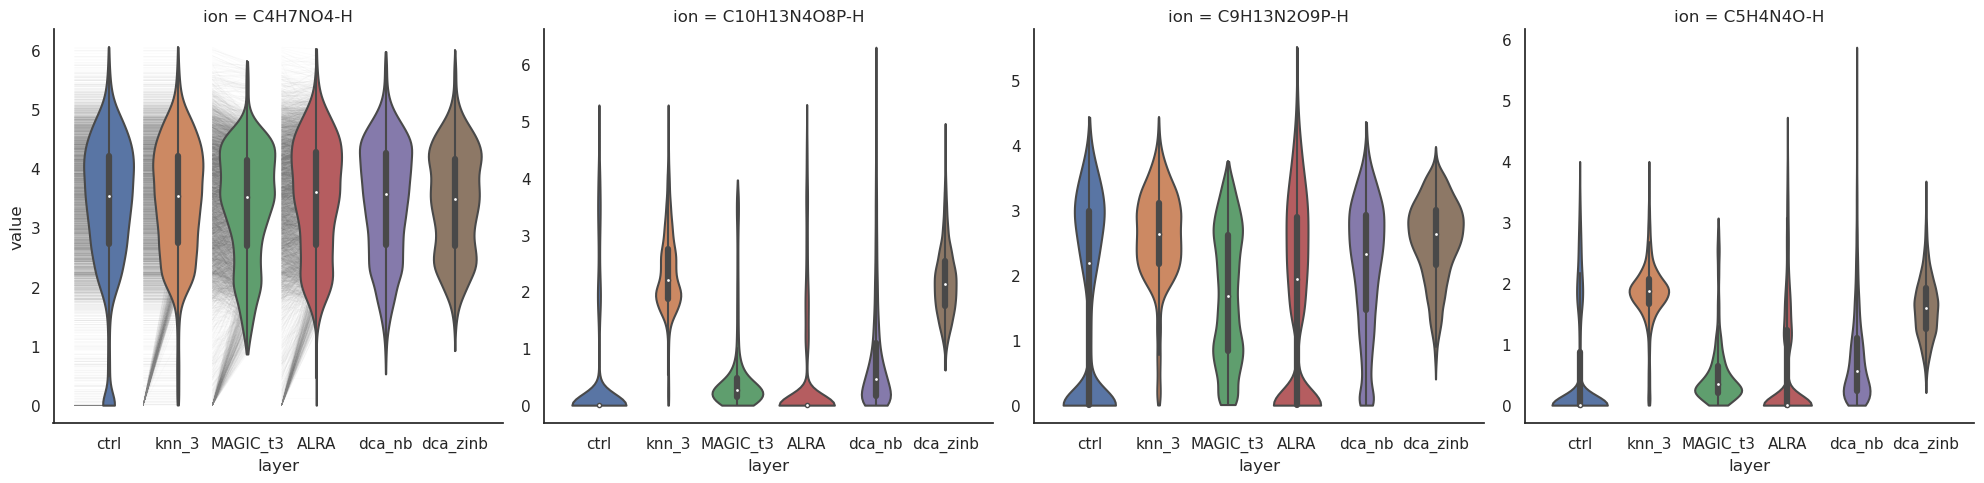

In [55]:
layer_order = ["ctrl", "knn_3", "MAGIC_t3", "ALRA", "dca_nb", "dca_zinb"]
paired_plot = sns.catplot(
    data=long_ion_df.set_index("cell_id"),
    x="layer",
    x_order=layer_order,
    col="ion",
    col_wrap=4,
    y="value",
    alpha=0.2,
    kind="violin",
    cut=0,
    sharey=False,
)

for (row, col, hue), data_table in list(paired_plot.facet_data()):
    ctrl_df = data_table[data_table["layer"] == "ctrl"]
    imp_df = data_table
    merge_df = pd.merge(
        ctrl_df, imp_df, left_index=True, right_index=True, suffixes=("_ctrl", "_imp")
    )

    for i, layer in enumerate(layer_order):
        for j, row in merge_df[merge_df["layer_imp"] == layer].iterrows():
            paired_plot.axes[col].plot(
                [i - 0.5, i],
                [row["value_ctrl"], row["value_imp"]],
                color="grey",
                linewidth=0.5,
                alpha=0.03,
                zorder=-1,
            )

paired_plot.set_ylabels("normalized, log ion intensity")

In [52]:
ion_comp_df = long_ion_df.pivot(
    index=["cell_id", "layer", "sample", "condition"], columns="ion", values="value"
).reset_index()
ion_comp_df

ion     cell_id     layer sample condition  C10H13N4O8P-H  C4H7NO4-H  \
0      10000_E1      ALRA     E1     NStim       0.000000   2.051473   
1      10000_E1  MAGIC_t3     E1     NStim       0.003817   1.971594   
2      10000_E1      ctrl     E1     NStim       0.000000   2.028445   
3      10000_E1    dca_nb     E1     NStim       0.003206   2.112282   
4      10000_E1  dca_zinb     E1     NStim       2.697321   2.178270   
...         ...       ...    ...       ...            ...        ...   
47551    999_B3  MAGIC_t3     B3       2DG       0.155542   4.485177   
47552    999_B3      ctrl     B3       2DG       0.000000   4.806341   
47553    999_B3    dca_nb     B3       2DG       0.316325   4.635088   
47554    999_B3  dca_zinb     B3       2DG       1.847160   4.457521   
47555    999_B3     knn_3     B3       2DG       1.901884   4.806341   

ion    C5H4N4O-H  C9H13N2O9P-H  
0       0.000000      0.000000  
1       0.282864      0.496096  
2       0.000000      0.000000  
3       0.374351      0.867033  
4       2.124666      2.373257  
...          ...           ...  
47551   0.407141      2.856160  
47552   0.000000      3.434275  
47553   0.675779      3.135501  
47554   1.560044      2.886786  
47555   1.956978      3.434275  

[47556 rows x 8 columns]

In [53]:
for i in range(0, len(analysis_ions), 2):
    i_grid = sns.FacetGrid(
        ion_comp_df[ion_comp_df["layer"].isin(layers_direct_comp)],
        col="layer",
        col_order=layers_direct_comp,
        row="condition",
        margin_titles=True,
        height=2,
        palette="cividis",
    )
    i_plot = i_grid.map_dataframe(
        sns.scatterplot, x=analysis_ions[i], y=analysis_ions[i + 1], s=2, linewidth=0
    )
    i_plot.add_legend()
    scid.evaluation.utils.print_stat_info_on_grid(i_grid)

NameError: name 'layers_direct_comp' is not defined

Analysis of DEGs

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.exp

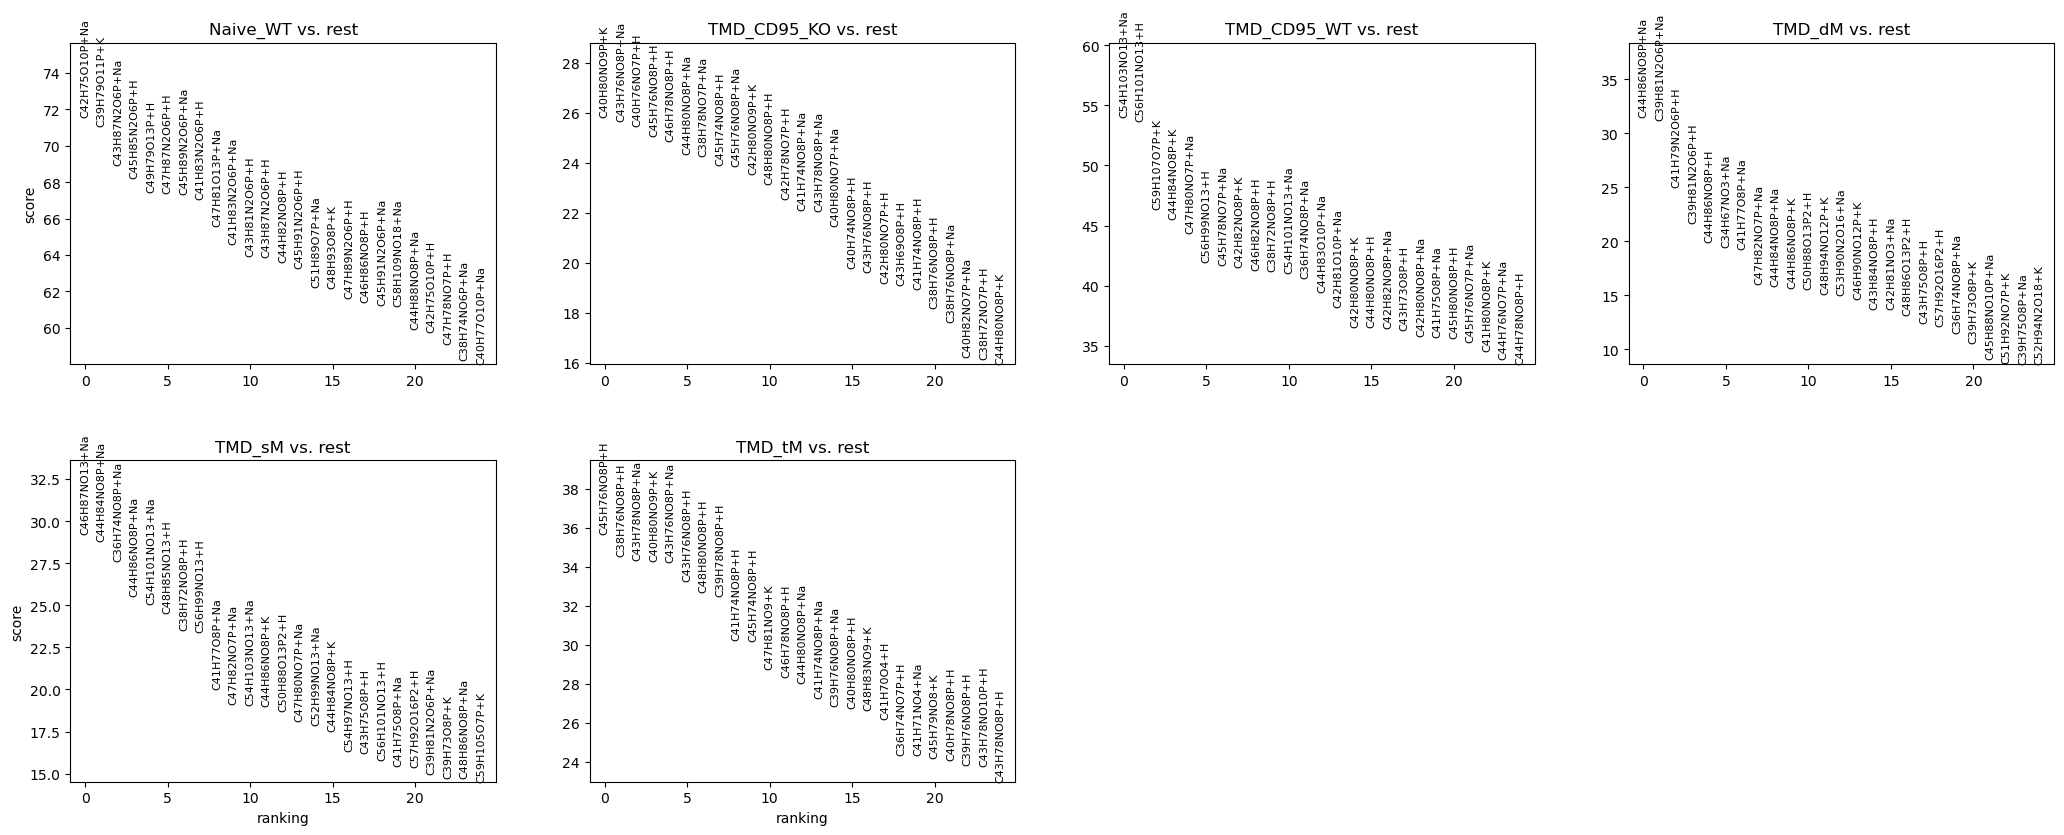

In [77]:
sc.tl.rank_genes_groups(adata, "condition", method="wilcoxon", key_added="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

In [88]:
set_list = []

layers = list(
    set(adata.layers.keys()).difference(
        ["dca_nb-conddisp", "dca_zinb-conddisp", "fancy_softbi"]
    )
)

for layer in layers:
    adata_imp = adata
    sc.tl.rank_genes_groups(
        adata_imp,
        use_raw=False,
        groupby="condition",
        method="wilcoxon",
        key_added=f"wilcoxon_{layer}",
        layer=layer,
    )
    # sc.pl.rank_genes_groups(adata_magic, n_genes=25, sharey=False, key = "wilcoxon")
    for condition in adata_imp.obs["condition"].unique():
        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=0.01,
            log2fc_min=0,
        )  # [['names']]
        df["layer"] = layer
        df["condition"] = condition
        df["direction"] = "up"
        df["cond"] = condition + " up"
        set_list.append(df)

        df = sc.get.rank_genes_groups_df(
            adata_imp,
            group=condition,
            key=f"wilcoxon_{layer}",
            pval_cutoff=0.01,
            log2fc_max=0,
        )  # [['names']]
        df["layer"] = layer
        df["condition"] = condition
        df["direction"] = "down"
        df["cond"] = condition + " down"
        set_list.append(df)

set_df = pd.concat(set_list)
set_df

names     scores  logfoldchanges  pvals  pvals_adj          layer  \
0      C7H10O6+Cl  57.758331        1.668083    0.0        0.0          knn_1   
1       C4H7NO4-H  54.787544        1.754269    0.0        0.0          knn_1   
2       C5H9NO4-H  47.813053        1.923848    0.0        0.0          knn_1   
3   C10H17N3O6S-H  46.363472        1.591855    0.0        0.0          knn_1   
4        C6H8O7-H  46.035248        1.441606    0.0        0.0          knn_1   
..            ...        ...             ...    ...        ...            ...   
90  C10H17N3O6S-H -47.147392       -3.081924    0.0        0.0  fancy_itersvd   
91    C9H13N5O3-H -47.195267       -2.943028    0.0        0.0  fancy_itersvd   
92      C5H7NO3-H -48.961758       -2.457957    0.0        0.0  fancy_itersvd   
93     C16H14O2-H -51.650887       -3.594124    0.0        0.0  fancy_itersvd   
94      C5H9NO4-H -52.319443       -3.881531    0.0        0.0  fancy_itersvd   

   condition direction        cond  
0        2DG        up      2DG up  
1        2DG        up      2DG up  
2        2DG        up      2DG up  
3        2DG        up      2DG up  
4        2DG        up      2DG up  
..       ...       ...         ...  
90     NStim      down  NStim down  
91     NStim      down  NStim down  
92     NStim      down  NStim down  
93     NStim      down  NStim down  
94     NStim      down  NStim down  

[19172 rows x 9 columns]

In [89]:
from sklearn.metrics import jaccard_score

overlap_list = []
for cond in set_df["cond"].unique():
    for layer1 in layers:
        for layer2 in layers:
            set1 = set(
                set_df[(set_df["cond"] == cond) & (set_df["layer"] == layer1)]["names"]
            )
            set2 = set(
                set_df[(set_df["cond"] == cond) & (set_df["layer"] == layer2)]["names"]
            )
            array1 = np.array([1 if x in set1 else 0 for x in set(set1.union(set2))])
            array2 = np.array([1 if x in set2 else 0 for x in set(set1.union(set2))])

            # print(f"{cond} + {layer1} + {set1}")
            # print(f"{cond} + {layer2} + {set2}")
            # print(jaccard_score(array1, array2))
            overlap_list.append(
                dict(
                    cond=cond,
                    direction=set_df[(set_df["cond"] == cond)]["direction"].iloc[0],
                    condition=set_df[(set_df["cond"] == cond)]["condition"].iloc[0],
                    layer1=layer1,
                    layer2=layer2,
                    jaccard=jaccard_score(array1, array2),
                )
            )

In [95]:
overlap_df = pd.DataFrame(overlap_list)
overlap_df["cond2"] = overlap_df["cond"]
overlap_df["imputation 1"] = overlap_df["layer1"]
overlap_df["imputation 2"] = overlap_df["layer2"]
overlap_df = overlap_df[
    (~overlap_df["layer1"].isin(exclude_imps))
    & (~overlap_df["layer2"].isin(exclude_imps))
]

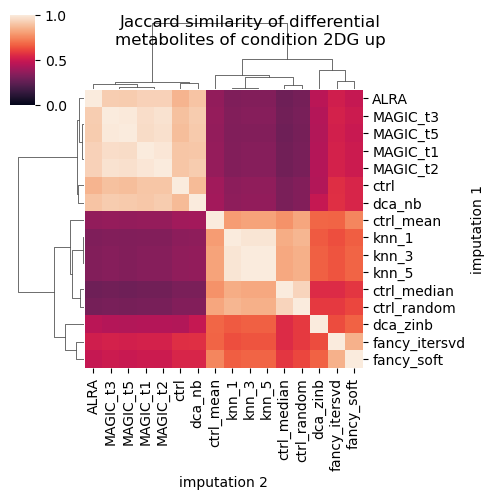

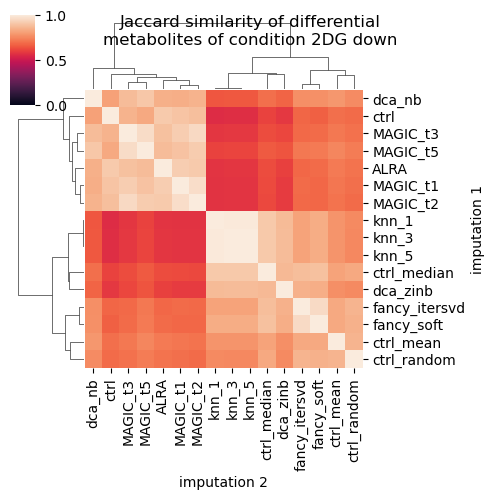

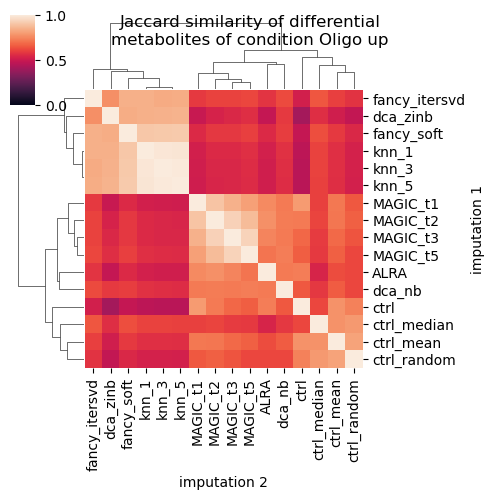

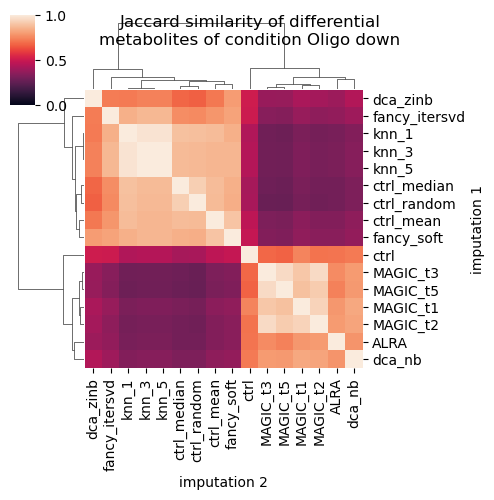

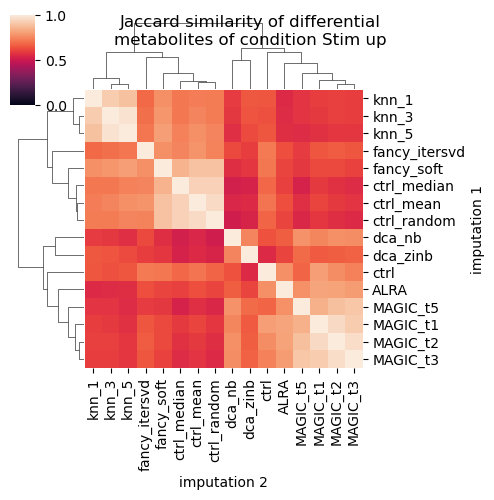

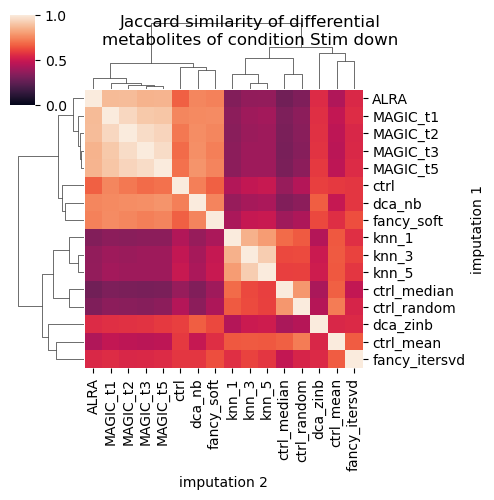

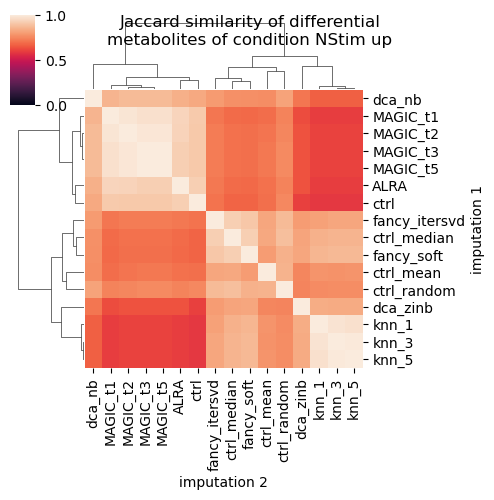

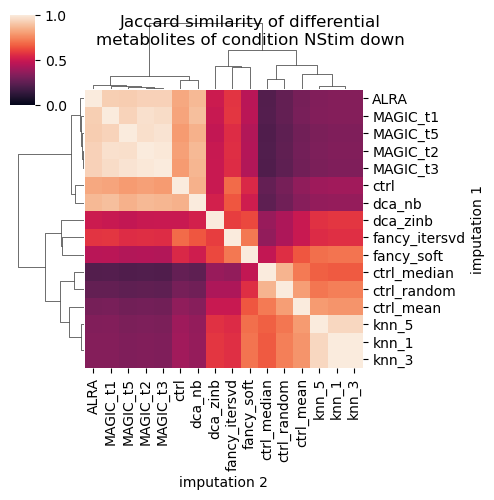

In [40]:
for condition in overlap_df.cond.unique():
    deg_ovl_plot = sns.clustermap(
        overlap_df[overlap_df["cond"] == condition]
        .pivot(index=["imputation 1"], columns=["imputation 2"], values="jaccard")
        .replace(np.nan, 0),
        vmin=0,
        vmax=1,
        figsize=(4, 4),
    )
    deg_ovl_plot.fig.suptitle(
        f"Jaccard similarity of differential\nmetabolites of condition {condition}"
    )

In [91]:
count_df = (
    set_df.groupby(["layer", "condition", "direction"])[["names"]]
    .count()
    .groupby(["layer"])[["names"]]
    .mean()
)
count_df["group"] = pd.cut(
    count_df["names"], bins=4, labels=["1", "2", "3", "4"]
).astype(str)

light_palette = sns.light_palette("green", n_colors=len(count_df["group"].unique()))

# Create a dictionary mapping each category to a color
category_colors = dict(zip(count_df["group"].unique().tolist(), light_palette))
# Map the colors to the categories
row_colors = count_df["group"].map(category_colors)
# row_colors.index = count_df['group']
row_colors

layer
ALRA             (0.9197652656492237, 0.9527224554855785, 0.919...
MAGIC_t1         (0.9197652656492237, 0.9527224554855785, 0.919...
MAGIC_t2         (0.9197652656492237, 0.9527224554855785, 0.919...
MAGIC_t3         (0.9197652656492237, 0.9527224554855785, 0.919...
MAGIC_t5         (0.9197652656492237, 0.9527224554855785, 0.919...
ctrl             (0.6131768437661491, 0.8024685650949609, 0.613...
ctrl_mean        (0.30658842188307456, 0.6522146747043431, 0.30...
ctrl_median      (0.30658842188307456, 0.6522146747043431, 0.30...
ctrl_random      (0.30658842188307456, 0.6522146747043431, 0.30...
dca_nb           (0.9197652656492237, 0.9527224554855785, 0.919...
dca_zinb         (0.9197652656492237, 0.9527224554855785, 0.919...
fancy_itersvd                       (0.0, 0.5019607843137255, 0.0)
fancy_multi                         (0.0, 0.5019607843137255, 0.0)
fancy_soft                          (0.0, 0.5019607843137255, 0.0)
knn_1                               (0.0, 0.501960784313

/tmp/ipykernel_1205/2502517308.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updown_df = overlap_df.groupby(['imputation 1', 'imputation 2', 'direction']).mean().reset_index().pivot(index=['direction', 'imputation 1'], columns=['imputation 2'], values='jaccard').replace(np.nan, 0)


Text(0.5, 0.98, 'Jaccard similarity of differential\nmetabolites (down, mean)')

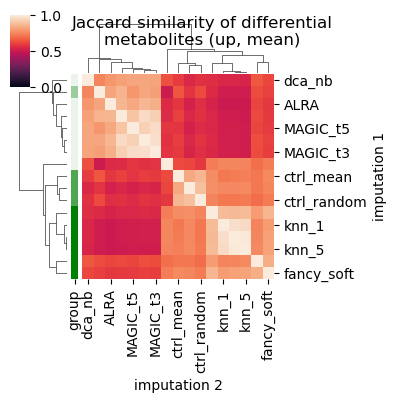

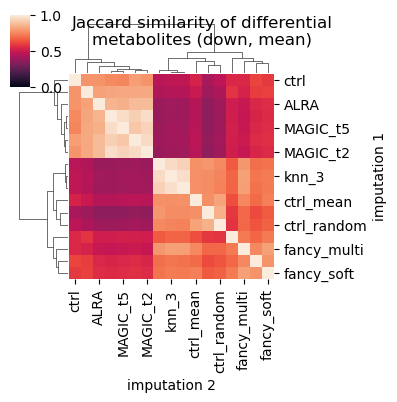

In [92]:
updown_df = (
    overlap_df.groupby(["imputation 1", "imputation 2", "direction"])
    .mean()
    .reset_index()
    .pivot(
        index=["direction", "imputation 1"], columns=["imputation 2"], values="jaccard"
    )
    .replace(np.nan, 0)
)
size = 4
deg_ovl_plot = sns.clustermap(
    updown_df[updown_df.index.get_level_values("direction") == "up"].reset_index(
        "direction", drop=True
    ),
    vmin=0,
    vmax=1,
    figsize=(size, size),
    row_colors=row_colors,
)
deg_ovl_plot.fig.suptitle(f"Jaccard similarity of differential\nmetabolites (up, mean)")

deg_ovl_plot = sns.clustermap(
    updown_df[updown_df.index.get_level_values("direction") == "down"].reset_index(
        "direction", drop=True
    ),
    vmin=0,
    vmax=1,
    figsize=(size, size),
)
deg_ovl_plot.fig.suptitle(
    f"Jaccard similarity of differential\nmetabolites (down, mean)"
)

/tmp/ipykernel_1205/2698155428.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  overlap_df.groupby(['imputation 1', 'imputation 2']).mean().reset_index().pivot(index=['imputation 1'], columns=['imputation 2'], values='jaccard').replace(np.nan, 0),


Text(0.5, 0.98, 'Jaccard similarity of differential\nmetabolites (mean)')

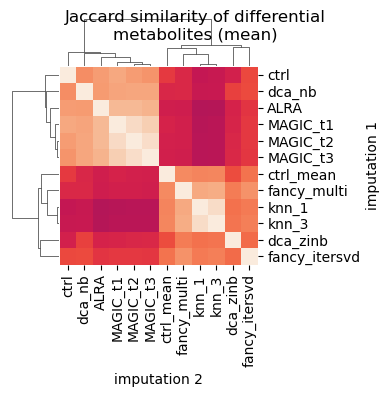

In [96]:
deg_ovl_plot = sns.clustermap(
    overlap_df.groupby(["imputation 1", "imputation 2"])
    .mean()
    .reset_index()
    .pivot(index=["imputation 1"], columns=["imputation 2"], values="jaccard")
    .replace(np.nan, 0),
    vmin=0,
    vmax=1,
    figsize=(size, size),
    cbar_pos=None,
)
deg_ovl_plot.fig.suptitle(f"Jaccard similarity of differential\nmetabolites (mean)")

In [100]:
hvg_set_list = []
for layer in adata.layers.keys():
    adata_imp = adata.copy()
    sc.pp.highly_variable_genes(
        adata, layer=layer, n_top_genes=None, flavor="cell_ranger"
    )
    df = adata.var[adata.var["highly_variable"]][["annotation_id"]]
    df["layer"] = layer
    df["condition"] = condition
    hvg_set_list.append(df.reset_index())

hvg_set_df = pd.concat(hvg_set_list)
hvg_set_df

index  annotation_id        layer condition
0       C2H5O5P-H      C2H5O5P-H         ctrl     NStim
1       C3H4O4+Cl      C3H4O4+Cl         ctrl     NStim
2      C3H5O6P+Cl     C3H5O6P+Cl         ctrl     NStim
3      C3H5O7P+Cl     C3H5O7P+Cl         ctrl     NStim
4     C3H7NO5S+Cl    C3H7NO5S+Cl         ctrl     NStim
..            ...            ...          ...       ...
78  C16H19N3O5+Cl  C16H19N3O5+Cl  fancy_multi     NStim
79     C16H30O2-H     C16H30O2-H  fancy_multi     NStim
80     C18H34O2-H     C18H34O2-H  fancy_multi     NStim
81     C20H32O2-H     C20H32O2-H  fancy_multi     NStim
82     CH4NO5P+Cl     CH4NO5P+Cl  fancy_multi     NStim

[1756 rows x 4 columns]

Text(0.5, 0.98, 'Jaccard similarity of highly \nvariable metabolites')

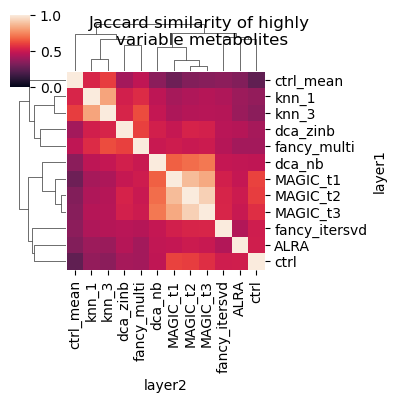

In [102]:
hvg_overlap_list = []
for layer1 in adata.layers.keys():
    for layer2 in adata.layers.keys():
        set1 = set(hvg_set_df[(hvg_set_df["layer"] == layer1)]["index"])
        set2 = set(hvg_set_df[(hvg_set_df["layer"] == layer2)]["index"])
        array1 = np.array([1 if x in set1 else 0 for x in set(set1.union(set2))])
        array2 = np.array([1 if x in set2 else 0 for x in set(set1.union(set2))])

        # print(f"{cond} + {layer1} + {set1}")
        # print(f"{cond} + {layer2} + {set2}")
        # print(jaccard_score(array1, array2))
        hvg_overlap_list.append(
            dict(
                cond=cond,
                layer1=layer1,
                layer2=layer2,
                jaccard=jaccard_score(array1, array2),
            )
        )

hvg_overlap_df = pd.DataFrame(hvg_overlap_list)
hvg_overlap_df = hvg_overlap_df[
    (~hvg_overlap_df["layer1"].isin(exclude_imps))
    & (~hvg_overlap_df["layer2"].isin(exclude_imps))
]

hvg_plot = sns.clustermap(
    hvg_overlap_df.reset_index()
    .pivot(index=["layer1"], columns=["layer2"], values="jaccard")
    .replace(np.nan, 0),
    vmin=0,
    vmax=1,
    figsize=(4, 4),
    # cmap='cividis'
)
hvg_plot.fig.suptitle(f"Jaccard similarity of highly \nvariable metabolites")